## Финальный проект: Телеком.

**Dataset Description:**
    
   Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.
   
    
**Данные:**

 Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
 
 * `contract` — информация о договорах;
 * `personal` — персональные данные клиентов;
 * `internet` — информация об интернет-услугах; 
 * `phone` — информация об услугах телефонии;
 
 Таблица `telecom.contract`:
 * `customerID` — ID абонента;
 * `BeginDate` — дата начала действия договора;
 * `EndDate` — дата окончания действия договора;
 * `Type` — тип оплаты: раз в год-два или ежемесячно;
 * `PaperlessBilling` — электронный расчётный лист;
 * `PaymentMethod` — тип платежа;
 * `MonthlyCharges` — расходы за месяц;
 * `TotalCharges` — общие расходы абонента.
 
  Таблица `telecom.personal`:
 * `customerID` — ID пользователя;
 * `gender` — пол;
 * `SeniorCitizen` — является ли абонент пенсионером;
 * `Partner` — есть ли у абонента супруг или супруга;
 * `Dependents` — есть ли у абонента дети.
 
  Таблица `telecom.internet`:
 * `customerID` — ID пользователя;
 * `InternetService` — тип подключения;
 * `OnlineSecurity` — блокировка опасных сайтов;
 * `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
 * `DeviceProtection` — антивирус;
 * `TechSupport` — выделенная линия технической поддержки;
 * `StreamingTV` — стриминговое телевидение;
 * `StreamingMovies` — каталог фильмов.
 
  Таблица `telecom.phone`:
 * `customerID` — ID пользователя;
 * `MultipleLines` — подключение телефона к нескольким линиям одновременно.
 
 Информация о договорах актуальна на 1 февраля 2020.

**Цели:**

 * Разработка модели для прогноза оттока клиентов. Значение метрики ROC-AUC должно быть не менее 0.85.
 * EDA анализ данных.
 * Анализ важности основных входных признаков, влияющих на отток клиентов.
 * Бизнес-рекомендации заказчику.
 
**Структура проекта:**
ЗДЕСЬ БУДЕТ СОДЕРЖАНИЕ

**Предмет исследования:**

    Данные о клиентах компании.

**Методы:**
* Загрузка и ознакомление с данными
* Exploratory data analysis
* Machine learning
* Сверточные нейронные сети


**Используемые библитеки:**

* Numpy
* Pandas
* Keras
* Seaborn
* Matplotlib

## Импорт библиотек, объявление констант

Импортируем необходимые библиотеки и объявим константы:

In [1]:
!pip install psycopg2-binary 
!pip install missingno 
!pip install scikeras
!pip install shap
!pip install optuna
!pip install phik

import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib as plt
import catboost as cb
import shap
import optuna
import tensorflow as tf
import math
import phik

from sqlalchemy import create_engine
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



RANDOM_SEED = 240723
STUDY = False

sns.set(rc={'figure.figsize':(20, 7)})
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Подключение к базе данных

Сконфигурируем подключение к БД:

In [2]:
db_config = {
    'user': 'praktikum_student',
    'pwd': 'Sdf4$2;d-d30pp',
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432,
    'db': 'data-science-final'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создаем соединение:

In [3]:
engine = create_engine(connection_string)

На этапе подключения к базе данных мы сконфигурировали подключение.

## Загрузка данных

Произведем загрузку данных из таблиц: contract, personal, internet, phone в словарь `data_dict` в виде датафремов:

In [4]:
data_dict = {'telecom.contract': None,
             'telecom.personal': None,
             'telecom.internet': None,
             'telecom.phone': None
             }

for table_name, dataframe in data_dict.items():
    query = '''
    SELECT *
    FROM
    '''
    query += table_name
    query += ';'
    data_dict[table_name] = pd.read_sql_query(query, con=engine)

На этапе загрузки данных мы, посредством ранее созданного подключения, выполнили загрузку таблиц базы данных в словарь датасетов для дальнейшей обработки а анализа.

## EDA и предобработка данных

### contract

Исследовательский анализ данных начнем с датафрейма contract в котором представлены данные о договорах c клиентами.

Взглянем на общую информацию о датафрейме:

In [5]:
contract = data_dict['telecom.contract']

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Приведем названия столбцов к snake_case:

In [6]:
contract.columns = ['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
                    'payment_method', 'monthly_charges', 'total_charges']

Датафрейм `contract` имеет 8 столбцов и 7043 строк:
* **customer_id** — 7043 значений, тип данных **object**, пропусков нет;
* **begin_date** — 7043 значений, тип данных **object**, пропусков нет;
* **end_date** — 1869 значений, тип данных **object**, пропусков есть;
* **type** — 7043 значений, тип данных **object**, пропусков нет;
* **paperless_billing** — 7043 значений, тип данных **object**, пропусков нет;
* **payment_method** — 7043 значений, тип данных **object**, пропусков нет;
* **begin_date** — 7043 значений, тип данных **float64**, пропусков нет;
* **total_charges** — 7043 значений, тип данных **float64**, пропусков нет;

Посмотрим на первые строки:

In [7]:
contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


Оценим пропущенные значения:

In [8]:
contract.isna().sum()

customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

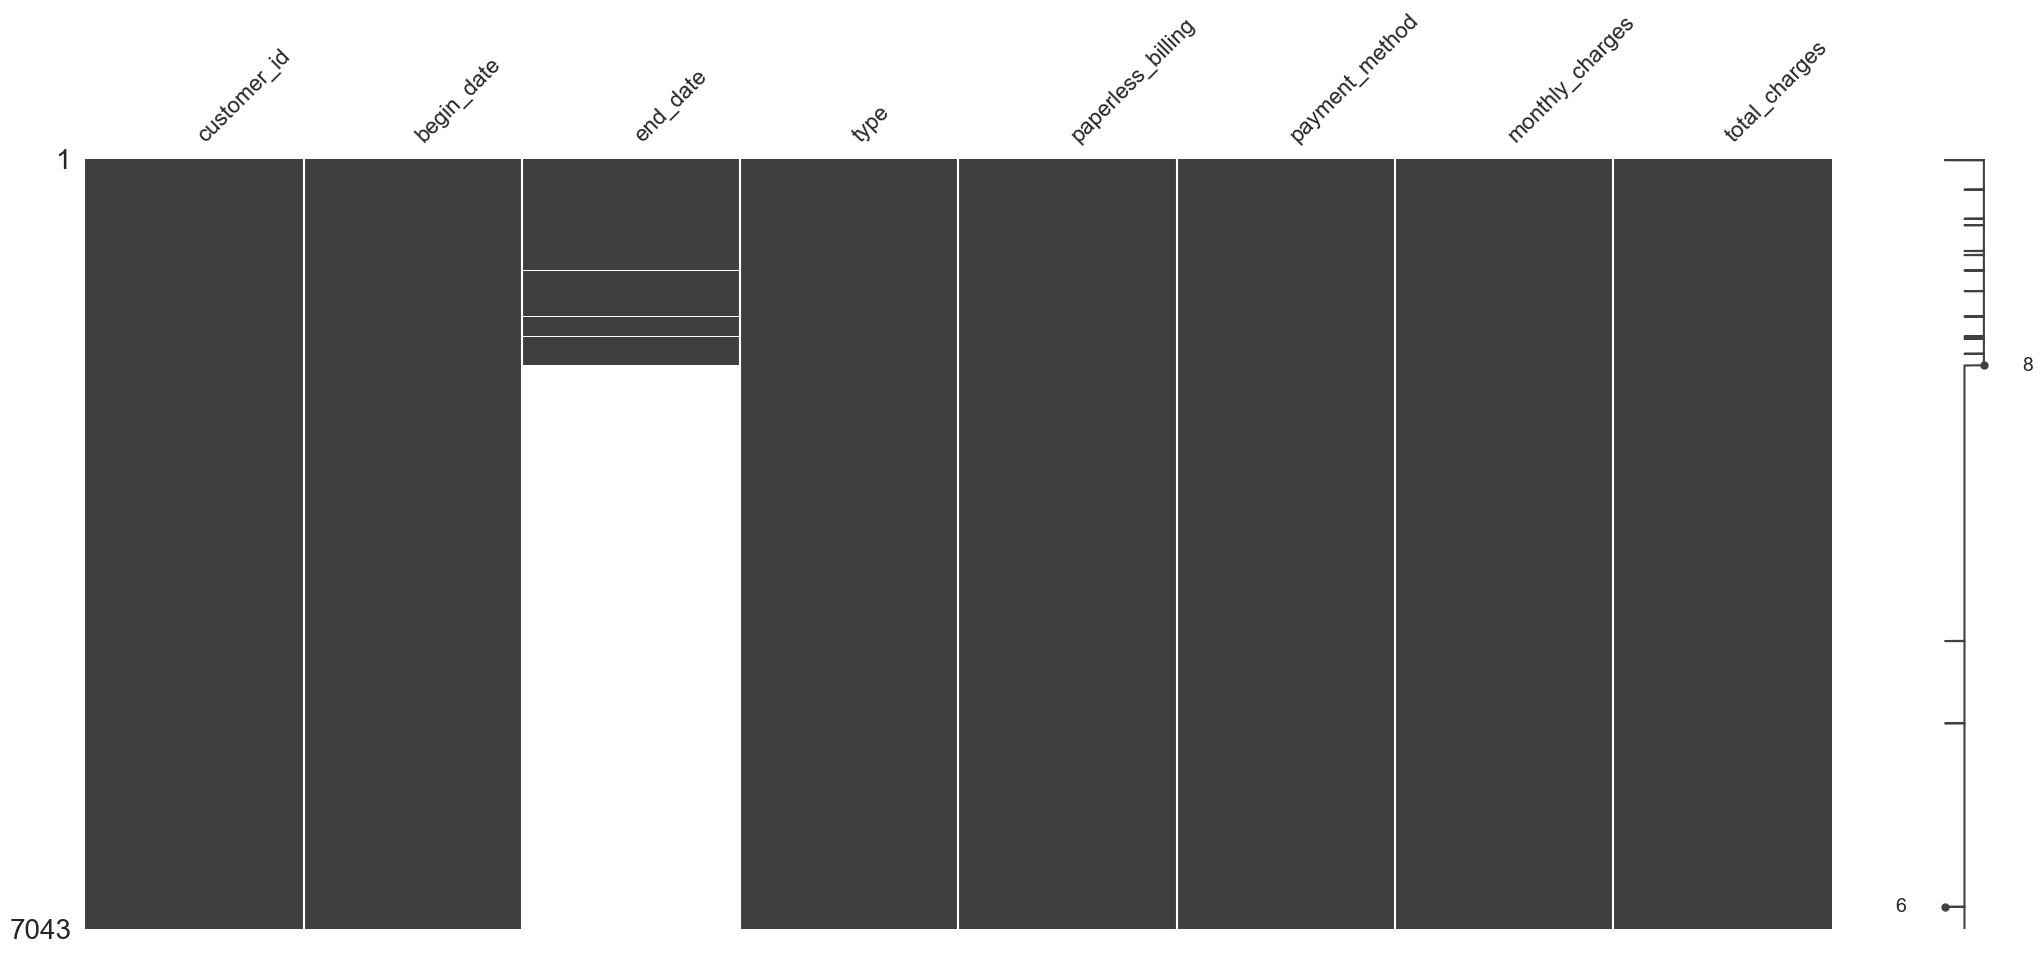

In [9]:
msno.matrix(contract);

Пропущенные значения в столбце **end_date** обусловлены тем что для действующих договоров не назначена дата окончания действия договора.

Данный столбец является целевым признаком: дата прекращения действия договора - потерянный клиент.

Корректным будет сначала выделить целевой признак а затем вычислить количество месяцев сотрудничества с каждым клиентом в качестве дополнительного признака а пропуски можно заполнить датой актуальности данных.

Выделим целевой признак:

In [10]:
contract['churn'] = contract['end_date'].apply(lambda x: 0 if x == None else 1)

Заполним пропущенные значения в столбце **end_date** для вычислению продолжительности действия договора:

In [11]:
contract['end_date'] = contract['end_date'].apply(
    lambda x: '2020-02-01' if x == None else x)

Данные в столбцах **end_date** и **begin_date** приведем к типу datatime:

In [12]:
contract[['end_date', 'begin_date']] = contract[[
    'end_date', 'begin_date']].apply(pd.to_datetime)

Вычислим разницу в месяцах между **end_date** и **begin_date** — срок жизни договора:

In [13]:
contract['month_duration'] = (
    contract['end_date'] - contract['begin_date']) / np.timedelta64(1, 'M')

Посмотрим на строки с пропущенными значениями в столбце **total_charges**:

In [14]:
contract[contract['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,month_duration
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0.0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0.0
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0.0
6,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0.0
7,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0.0
9,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0.0
10,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0.0
11,2775-SEFEE,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),61.90,NaN,0,0.0
4408,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0.0
5160,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0.0


Т.к. информация о договорах актуальна на 1 февраля 2020 и в строках с пропущенными значениями **total_charges** дата начала действия договора — 1 февраля 2020 мы имеем дело с только что заключенными договорами по которым еще не вносилась оплата.

Будет корректным удалить эти строки, информации о оттоке они ненесут:

In [15]:
contract = contract[contract['total_charges'].notna()]

Предобработка данных для датафрейма **contract** завершена, проведем анализ категориальных данных:

* Как соотноситься количество расторгнутых контрактов в зависимости от периода расчетов в контракте?:

Text(0.5, 1.0, 'Churn per type of contract payment period')

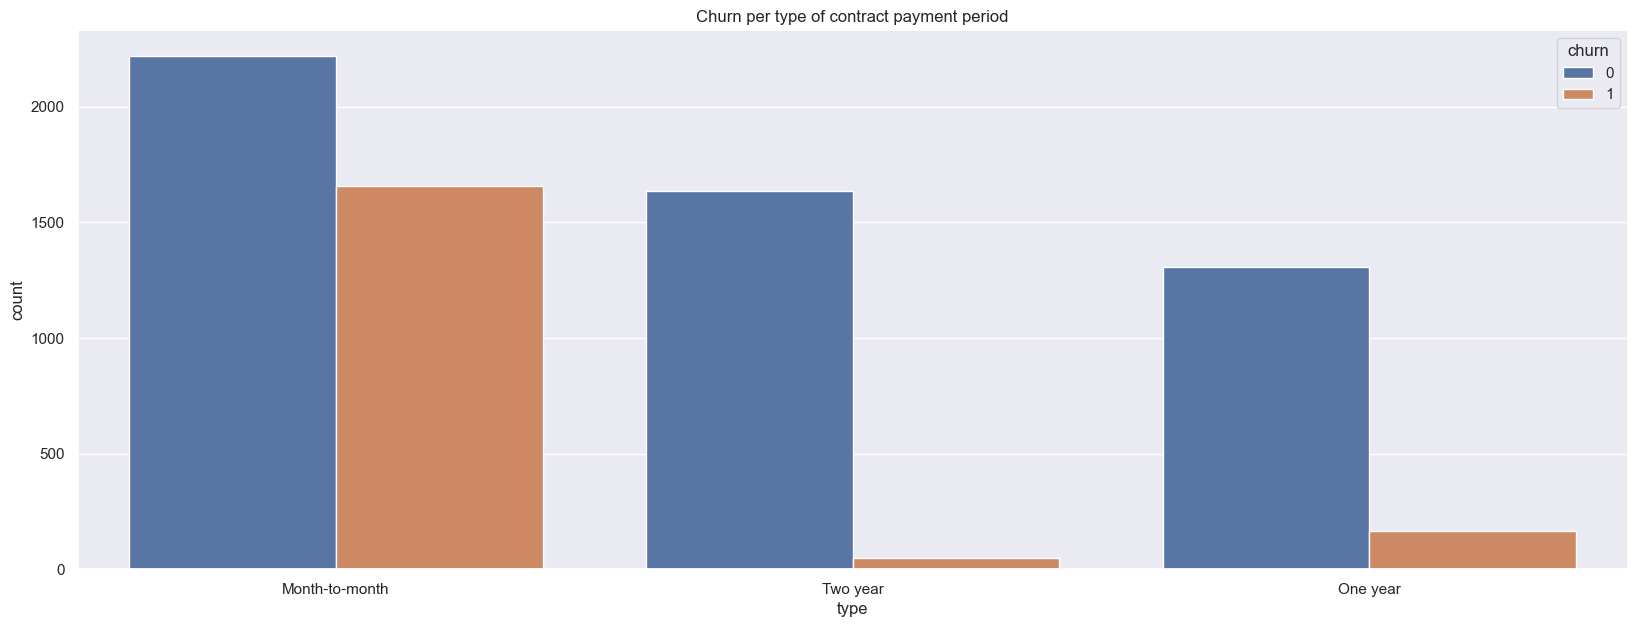

In [16]:
sns.countplot(data=contract, x='type', hue='churn').set_title(
    'Churn per type of contract payment period')

Судя по диаграмме **'Churn per type of contract payment period'** наибольшая доля клиентов расторгнувщих контракт оплачивала услуги помесячно.

* Как соотноситься количество расторгнутых контрактов в зависимости от типа счетов?:

Text(0.5, 1.0, 'Churn per type of paperless_billing')

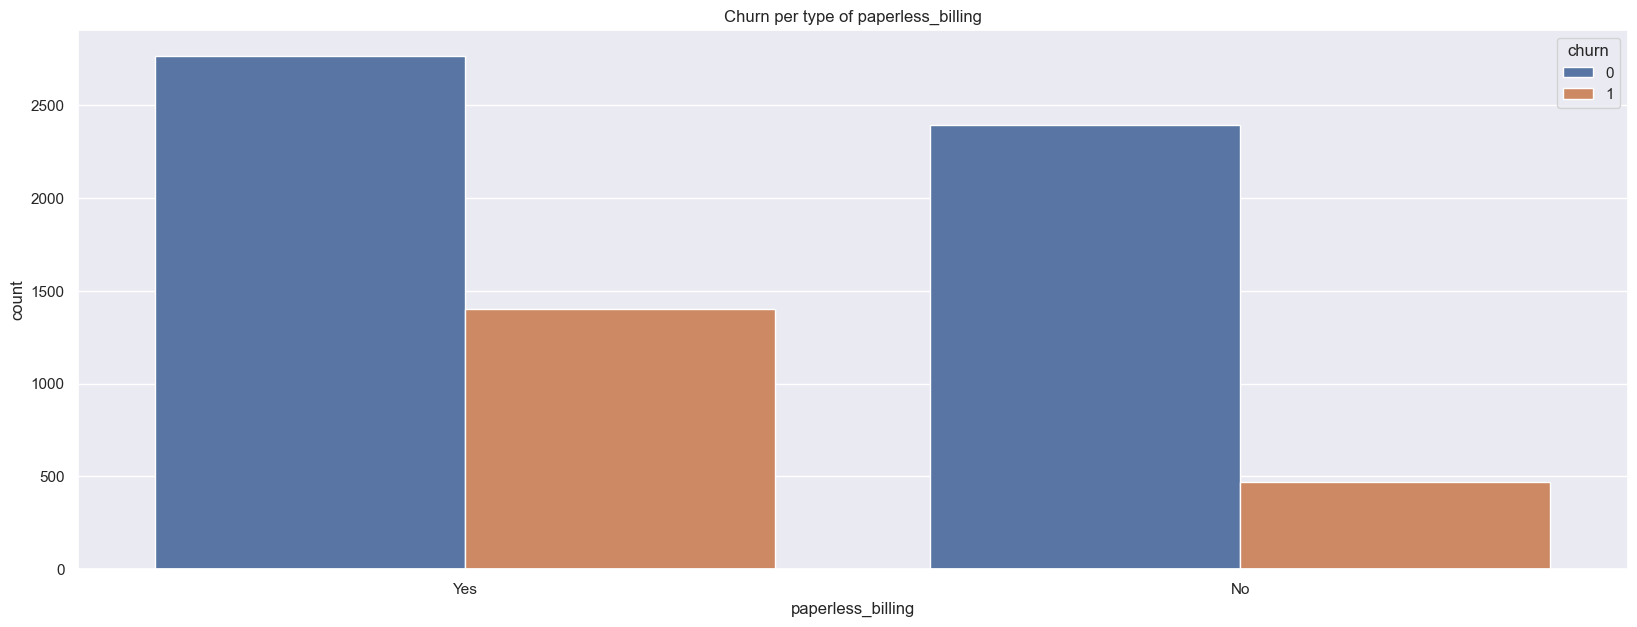

In [17]:
sns.countplot(data=contract, x='paperless_billing', hue='churn').set_title(
    'Churn per type of paperless_billing')

Судя по диаграмме **'Churn per type of paperless_billing'** наибольшая доля клиентов расторгнувщих контракт получала бумажные счета за услуги.

* Как соотноситься количество расторгнутых контрактов в зависимости от способа оплаты?:

Text(0.5, 1.0, 'Churn per type of payment')

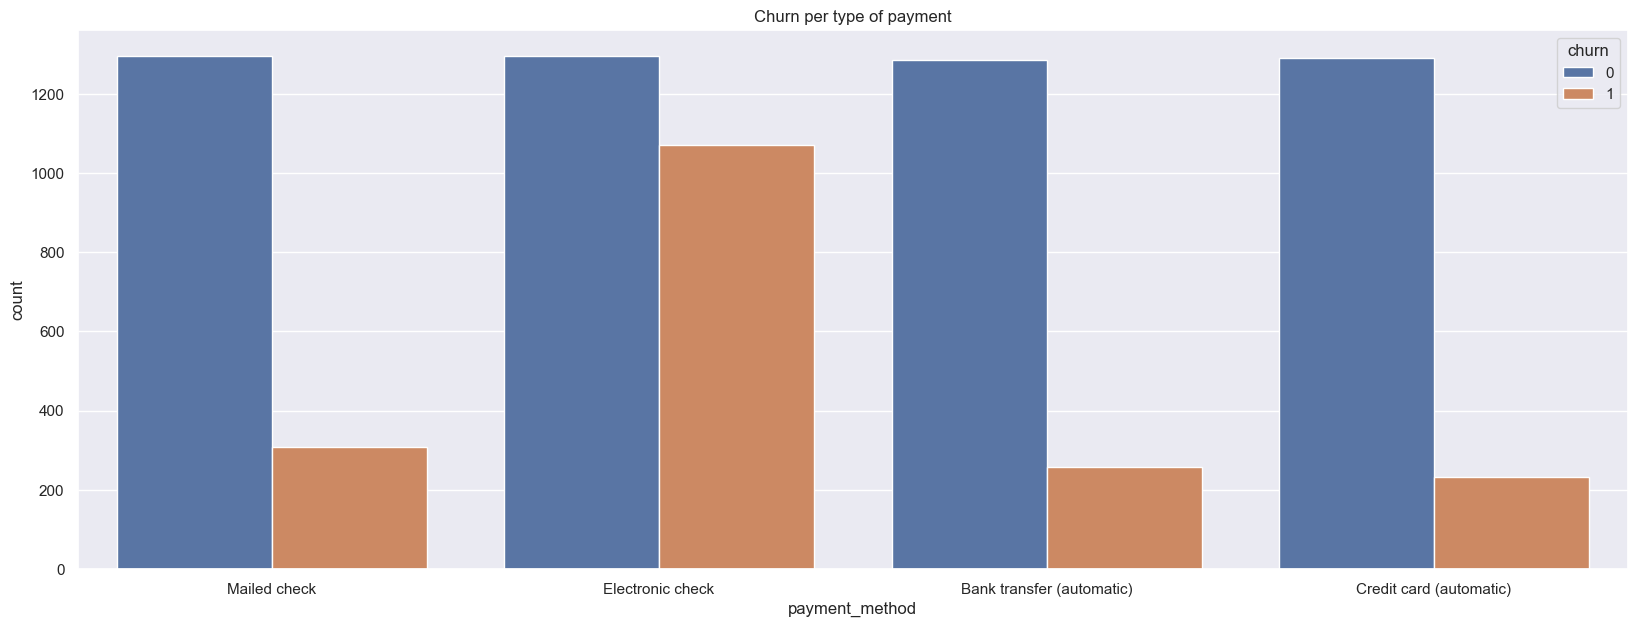

In [18]:
sns.countplot(data=contract, x='payment_method',
              hue='churn').set_title('Churn per type of payment')

Судя по диаграмме **'Churn per type of payment'** наибольшая доля клиентов расторгнувщих контракт предпочитала электронный счет за услуги.

Посмотрим на соотношение новых заключенных контрактов и расторгнутых контрактов в течении времени, помесячно:

Text(0.5, 1.0, 'New and churn contract per month')

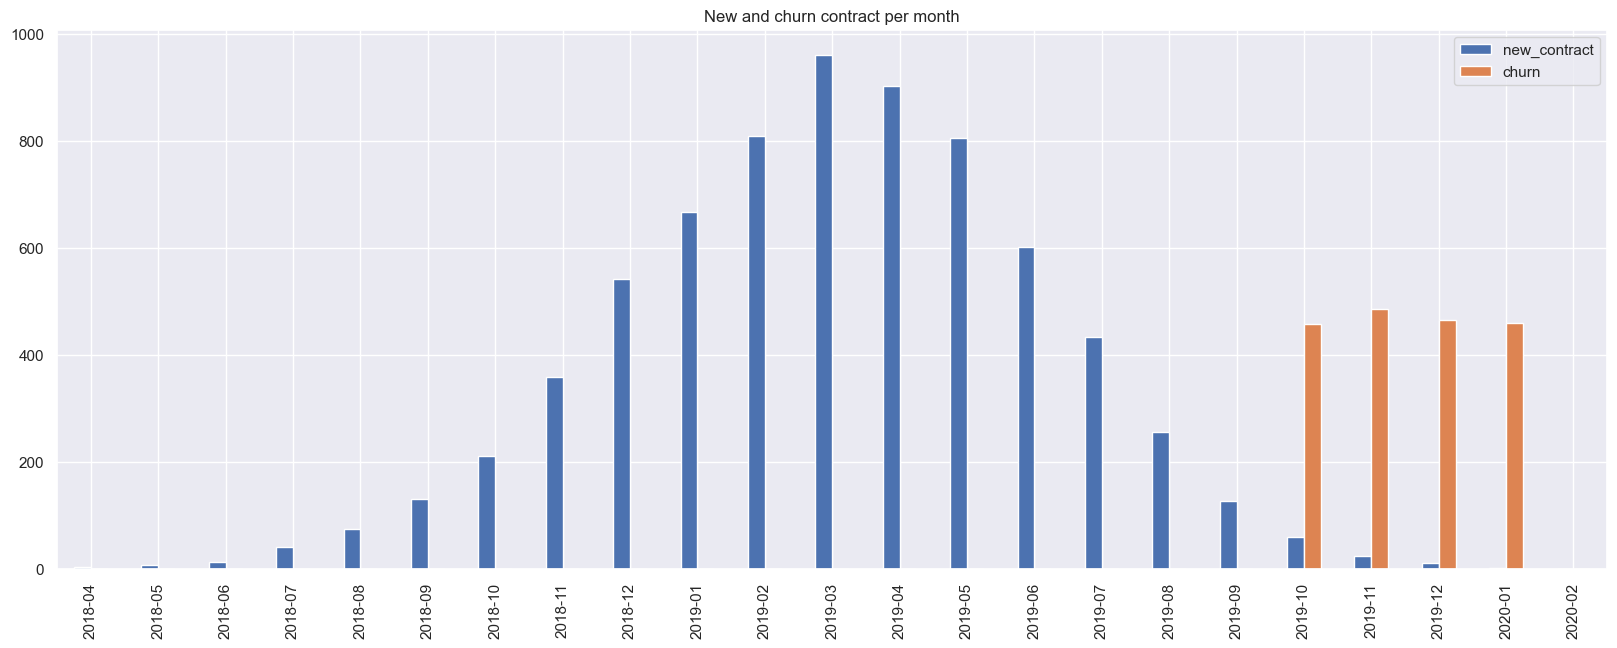

In [19]:
df1 = contract.groupby(contract.end_date.dt.to_period('M'))['churn'].agg('sum')
df2 = contract.groupby(contract.begin_date.dt.to_period('M'))[
    'customer_id'].agg('count')
t_table = pd.merge(df2, df1, left_index=True, right_index=True, how='outer')
t_table.columns = ['new_contract', 'churn']
t_table = t_table.fillna(0)
t_table.plot(kind='bar').set_title('New and churn contract per month')

Диаграмма **'New and churn contract per month'** показывает что распределение новых заключенных контрактов имеет нормально распределение с выраженным пиком по количеству в период в марте 2019 г., отток клиентов произошел в период с ноября 2019 по январь 2020 года, распределение оттока клиентов в разрезе вышеуказанного периода состовляет около 400 человек за каждый месяц.

В какой период были заключены контракты по которым наблюдается отток клиентов?

Text(0.5, 1.0, 'Start date of churn contract per month')

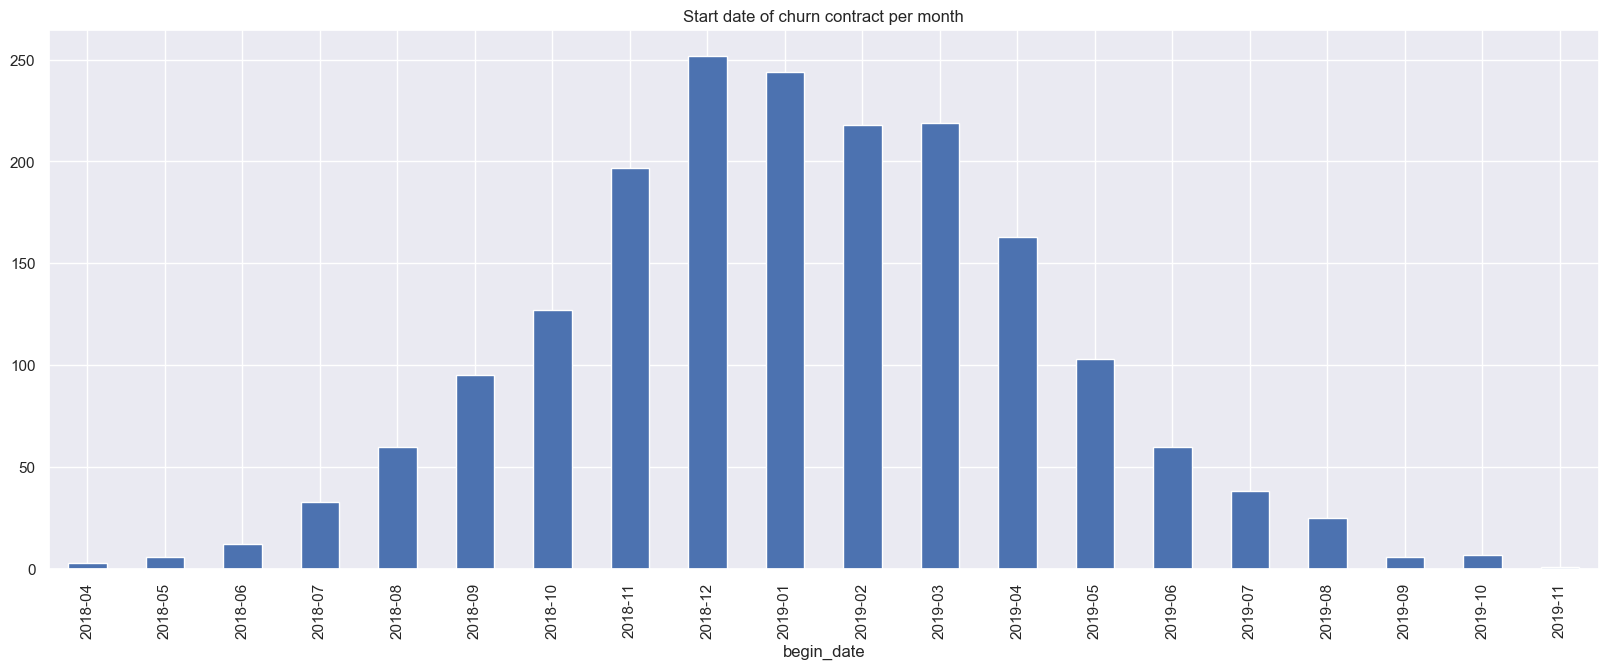

In [20]:
t_table = contract[contract.churn == 1].groupby(
    contract.begin_date.dt.to_period('M'))['customer_id'].agg('count')
t_table.plot(kind='bar').set_title('Start date of churn contract per month')

Как мы можем видеть из данных диаграммы **'Start date of churn contract per month'** распределение дат заключения расторгнутых контрактов повторяет форму всех заключенных контрактов в разрезе месяца заключения, но пик оттока наступает ранее и приходиться на окончание 2018 года.

Text(0.5, 1.0, 'Median monthy charges per month and churn')

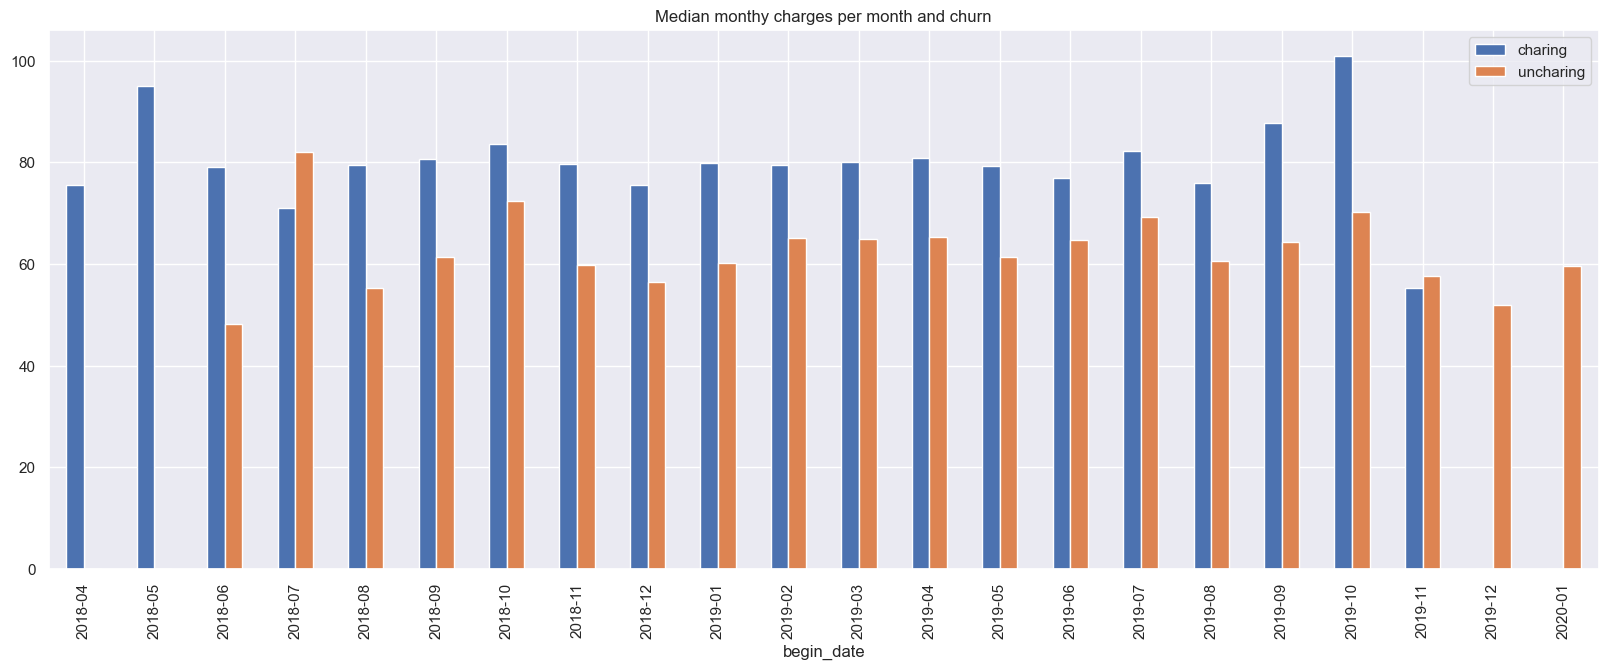

In [21]:
df1 = contract[contract.churn == 1].groupby(contract.begin_date.dt.to_period('M'))[
    'monthly_charges'].agg('median')
df2 = contract[contract.churn == 0].groupby(contract.begin_date.dt.to_period('M'))[
    'monthly_charges'].agg('median')

t_table = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')
t_table.columns = ['charing', 'uncharing']
t_table.plot(kind='bar').set_title('Median monthy charges per month and churn')

Рассмотрев диаграмму 'Median monthy charges per month and churn' мы приходим к выводу что ушедшие клиенты всегда имели большие месячные расходы чем оставшиеся клиенты.

In [22]:
contract[contract.churn == 1].month_duration.median()

9.64516129032258

В среднем контракты на обслуживание разрывают через 9 месяцев

In [23]:
contract.groupby('churn')[['monthly_charges', 'total_charges']].agg('median')

,monthly_charges,total_charges
churn,,
0,64.45,1683.60
1,79.65,703.55


Общие расходы абонентов которые разрывают контракты ниже чем расходы абонентов с действующими контрактами, а месячный платеж выше.

Проверим совпадет ли количество месяцев вычисленное при помощи разности дат и количество месяцев вычисленное путем деления общих расходов на месячный расход?

In [24]:
contract.loc[:, 'check_contract_duration'] = contract['total_charges'] / \
    contract['monthly_charges']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
contract[['check_contract_duration', 'month_duration']].head()

,check_contract_duration,month_duration
2,2.008357,15.451613
4,2.144979,9.000000
5,8.233818,10.000000
8,29.065363,6.064516
12,48.566056,10.387097


Есть первое не совпадение.

In [26]:
contract[0:1]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,month_duration,check_contract_duration
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,15.451613,2.008357


Контракт данного абонета был действителен 15 месяцев, но платил он всего 2 месяца.

Выделим количество проплаченных месяцев:

In [27]:
contract.loc[:, 'payment_month'] = (
    contract['total_charges'] / contract['monthly_charges']) - contract['month_duration']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
contract.sort_values(by='payment_month', ascending=False).head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,month_duration,check_contract_duration,payment_month
2863,3910-MRQOY,2019-12-07,2020-02-01,Two year,No,Bank transfer (automatic),19.40,1496.45,0,1.806452,77.136598,75.330146
4655,9351-HXDMR,2019-11-22,2020-02-01,Two year,Yes,Credit card (automatic),110.90,8240.85,0,2.290323,74.308837,72.018514
2065,7083-MIOPC,2019-08-03,2020-02-01,Two year,No,Credit card (automatic),20.25,1566.90,0,5.870968,77.377778,71.506810
4575,2900-PHPLN,2019-10-09,2020-02-01,Two year,Yes,Credit card (automatic),19.55,1462.05,0,3.709677,74.785166,71.075489
2126,9880-TDQAC,2020-01-29,2020-02-01,Two year,Yes,Electronic check,60.00,4264.00,0,0.096774,71.066667,70.969892


На лицо не согласованность в данных об месячных расходах, всех расходов и длительности контракта т.е. клиенты могут годами не платить за услуги. Требуется консультация коллег.

Адекватного значения заполнения monthly_charges, total_charges нет, мы точно не можем сказать какая часть из данных скомпроментированна, пока-что оставляем все как есть.

In [29]:
contract = contract.drop(['check_contract_duration', 'monthly_charges', 'payment_month'], axis=1)

### Personal

Проведем ознакомление и анализ таблицы **personal**.

Взглянем на общую информацию о датафрейме:

In [30]:
personal = data_dict['telecom.personal']

personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Приведем названия столбцов к snake_case:

In [31]:
personal.columns = ['customer_id', 'gender',
                    'senior_citizen', 'partner', 'dependents']

Датафрейм `personal` имеет 5 столбцов и 7043 строк:
* **customer_id** — 7043 значений, тип данных **object**, пропусков нет;
* **gender** — 7043 значений, тип данных **object**, пропусков нет;
* **senior_citizen** — 7043 значений, тип данных **int64**, пропусков есть;
* **partner** — 7043 значений, тип данных **object**, пропусков нет;
* **dependents** — 7043 значений, тип данных **object**, пропусков нет;

Посмотрим на первые строки:

In [32]:
personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Оценим пропущенные значения:

In [33]:
personal.isna().sum()

customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Проверим на неявные дубликаты:

In [34]:
check_columns = ['gender', 'senior_citizen', 'partner','dependents']

for columns in check_columns:
    print(personal[columns].unique())

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


Проверим на уникальность столбец **customer_id**:

In [35]:
personal.customer_id.unique().shape[0]

7043

Все в порядке, все значения уникальны.

Предобработка данных для датафрейма **contract** завершена, для дальнейшего анализа датасета **personal**, нам необходимо соеденить его с датасетом **contract** по ключу **customer_id**:

In [36]:
df = contract.merge(personal, left_on='customer_id',
                    right_on='customer_id', how='left')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,total_charges,churn,month_duration,gender,senior_citizen,partner,dependents
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,108.15,1,15.451613,Male,0,No,No
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,151.65,1,9.000000,Female,0,No,No
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,820.50,1,10.000000,Female,0,No,No
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,3046.05,1,6.064516,Female,0,Yes,No
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),5036.30,1,10.387097,Male,0,No,No


In [37]:
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
total_charges        0
churn                0
month_duration       0
gender               0
senior_citizen       0
partner              0
dependents           0
dtype: int64

In [38]:
df = df.dropna()

In [39]:
df.shape

(7032, 13)

Проведем анализ новых данных:

* Как соотноситься пол клиента и количество расторгнутых контрактов?:

Text(0.5, 1.0, 'Churn per gender')

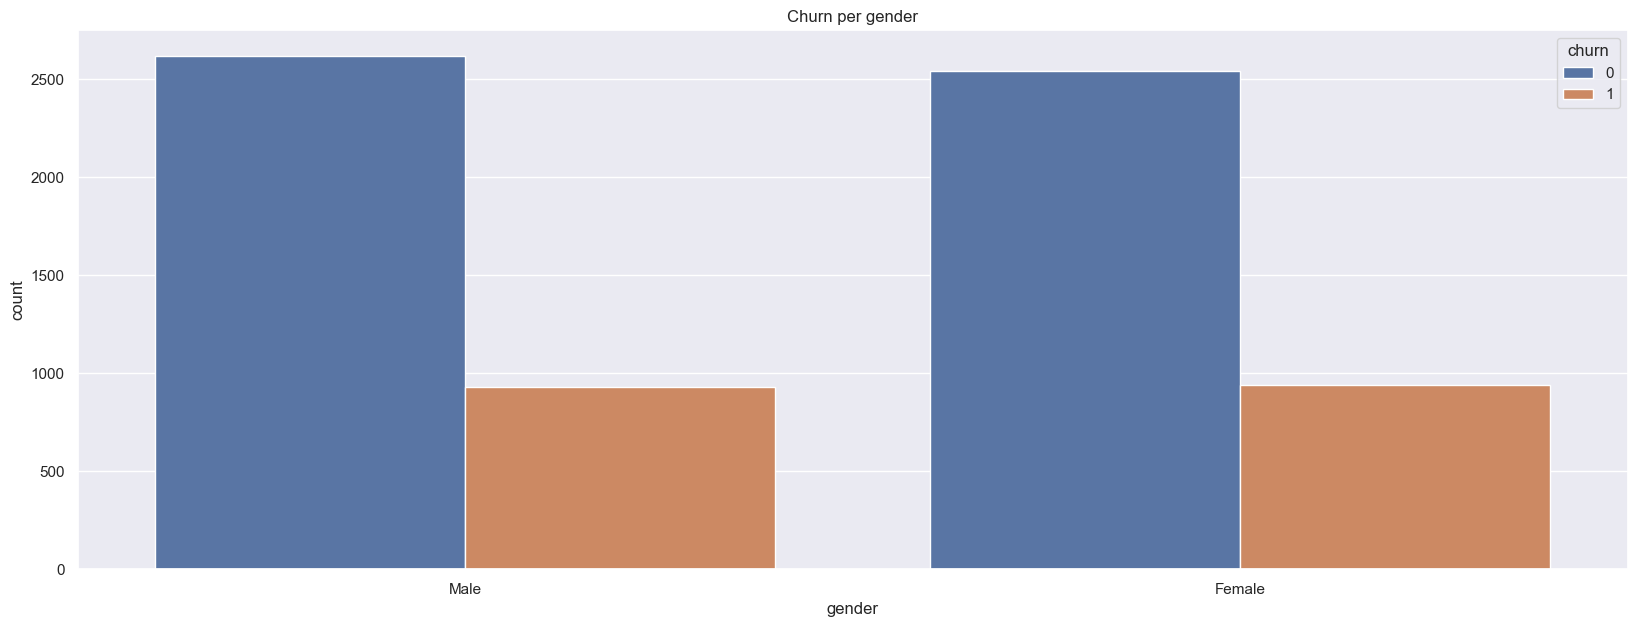

In [40]:
sns.countplot(data=df, x='gender', hue='churn').set_title('Churn per gender')

Как мы можем видеть по данным диаграммы **'Churn per gender'**: зависимости количества расторгнутых контрактов в разрезе пола клиента не наблюдается, причем у компании примерно равное количество абонентов обоих полов, признак **gender** не включаем в данные для обучения моделей.

* Влияет ли то что клиент является пенсионером на вероятность расторжения контракта?:

Text(0.5, 1.0, 'Churn per senior_citizen')

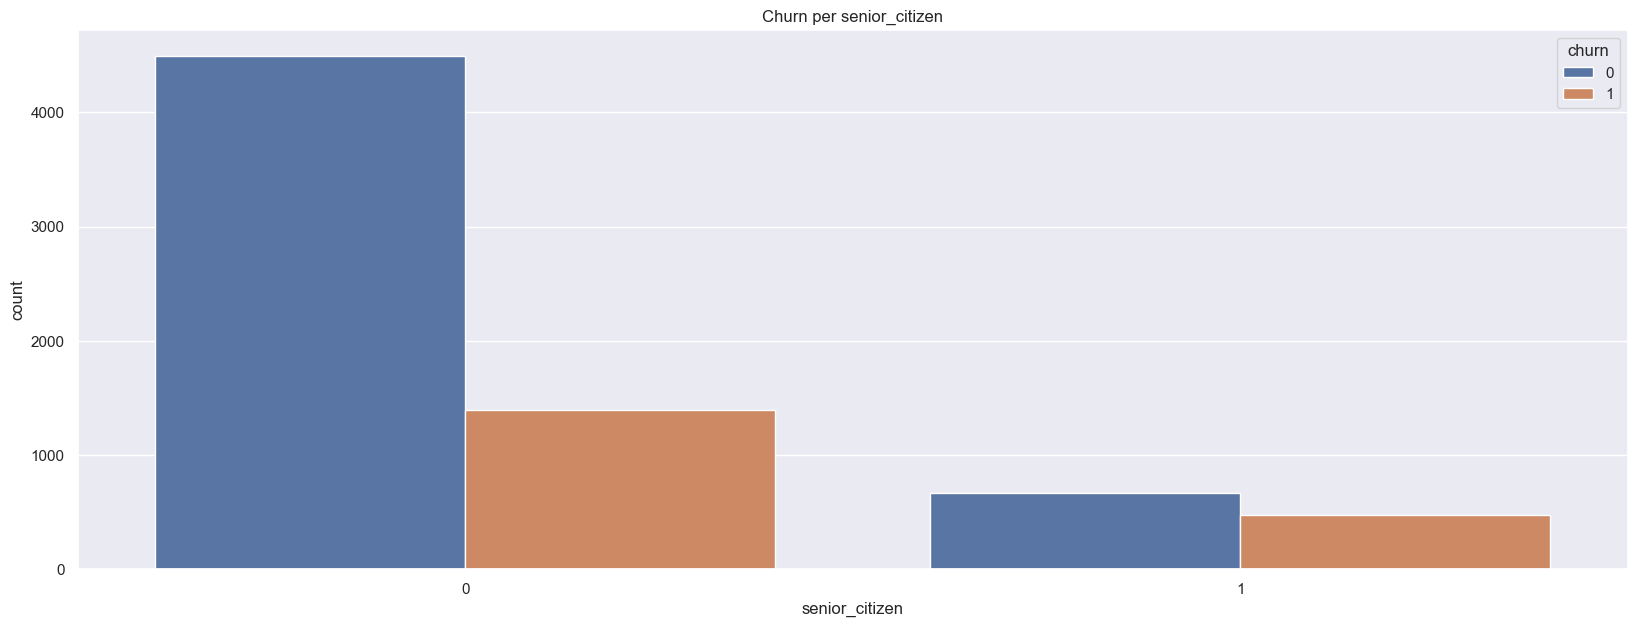

In [41]:
sns.countplot(data=df, x='senior_citizen', hue='churn').set_title(
    'Churn per senior_citizen')

Анализируя диаграмму **'Churn per gender'** приходим к выводу что пенсионеры чаще разрывают контракт услуг связи, хотя их доля намного меньше чем не пенсионеров.

А как обстоят дела с семейным положением клиентов, влияет ли наличие супруга или супруги на вероятность прекращения действия контракта?

Text(0.5, 1.0, 'Churn per partner')

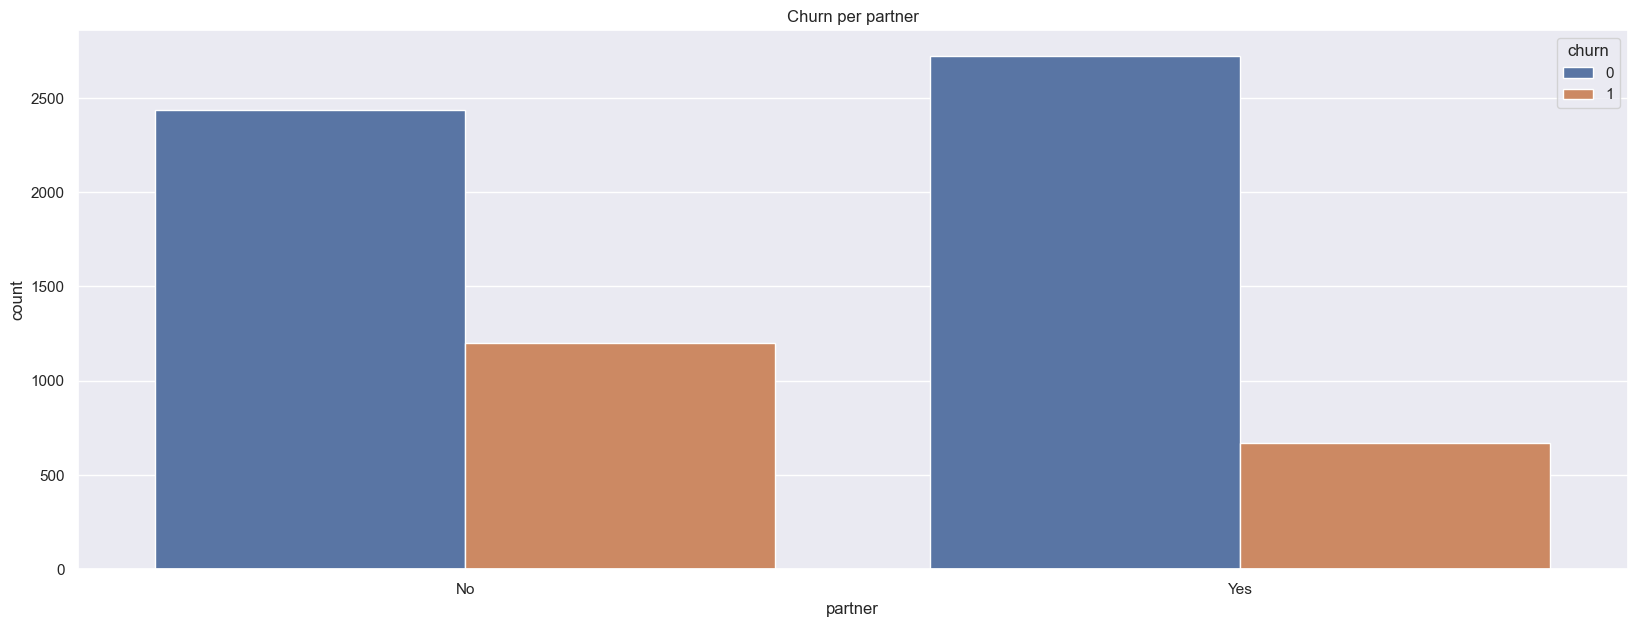

In [42]:
sns.countplot(data=df, x='partner', hue='churn').set_title('Churn per partner')

Клиенты имеющие супруга или супругу реже разрывают контракты, доли клиентов в браке и нет примерно равны.

Как влияет наличие детей на вероятность прекращения контракта:

Text(0.5, 1.0, 'Churn per dependents')

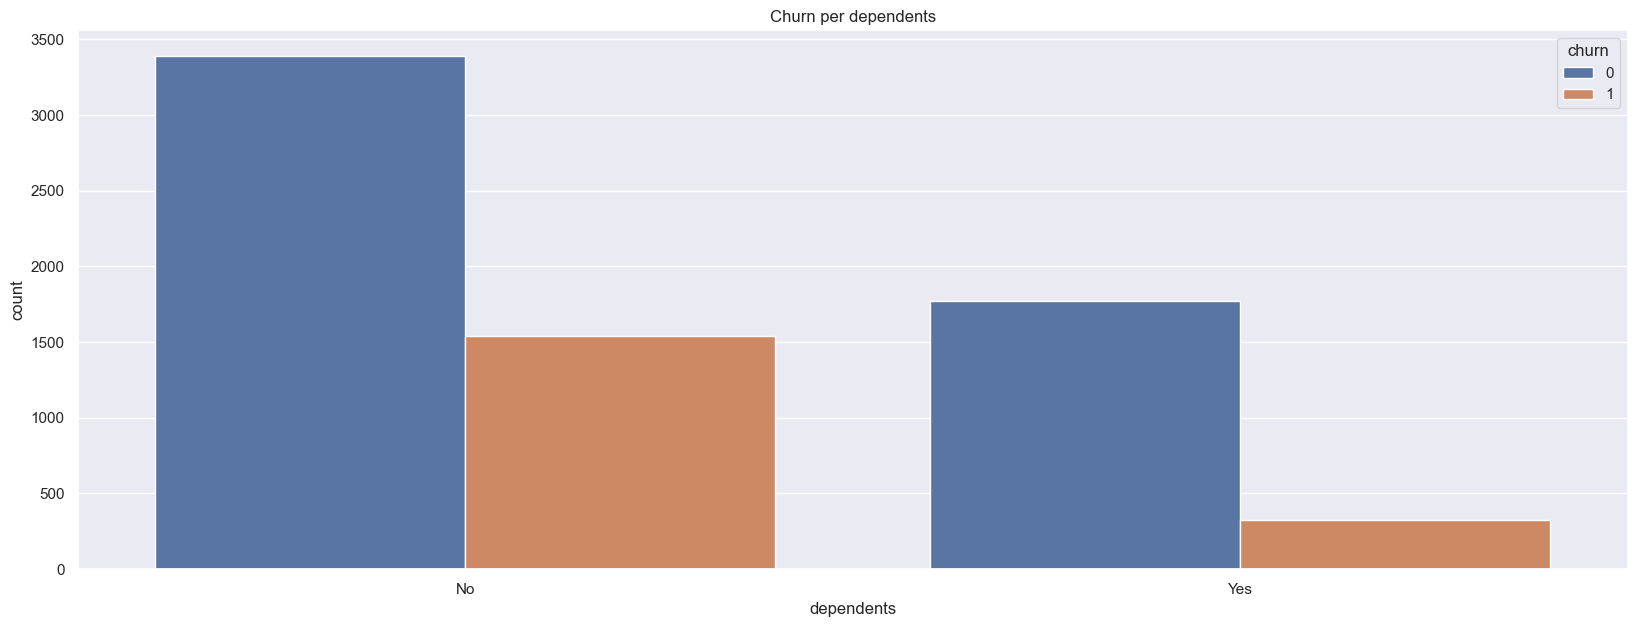

In [43]:
sns.countplot(data=df, x='dependents', hue='churn').set_title(
    'Churn per dependents')

Клиенты имеющие детей, реже разрывают контракты, доля клиентов без детей намного больше клиентов с детьми.

### Internet

Проведем ознакомление и анализ таблицы **internet**.

Взглянем на общую информацию о датафрейме:

In [44]:
internet = data_dict['telecom.internet']

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


Как мы можем видеть из таблице выше, у нас какая-то проблема с именами колонок, взглянем на несколько строк датасета:

In [45]:
internet.head()

,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


Имена колонок оказались в первой строке датасета, это может быть связанно с ошибкой таблицы базы SQL, в реальной ситуации можем проконсультироваться с коллегами ответсвенными за администрирование базы данных, в нашем случае извлечем имена колонок из первой строки и приведем их к snake_case:

In [46]:
internet.columns = internet[0:1].values.tolist()[0]
internet = internet.drop([0])
internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
                    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [47]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Датафрейм `internet` имеет 8 столбцов и 5517 строк:
* **customer_id** — 5517 значений, тип данных **object**, пропусков нет;
* **internet_service** — 5517 значений, тип данных **object**, пропусков нет;
* **online_security** — 5517 значений, тип данных **object**, пропусков нет;
* **online_backup** — 5517 значений, тип данных **object**, пропусков нет;
* **device_protection** — 5517 значений, тип данных **object**, пропусков нет;
* **tech_support** — 5517 значений, тип данных **object**, пропусков нет;
* **streaming_tv** — 5517 значений, тип данных **object**, пропусков нет;
* **streaming_movies** — 5517 значений, тип данных **object**, пропусков нет;

Судя по количеству строк в датасете **internet** (5517) в отношении уникальных записей customer_id в датафрейме **contract**(7043) не все клиенты пользуютя интернет-услугами.

Проверим на уникальность столбец **customer_id**:

In [48]:
internet.customer_id.unique().shape[0]

5517

Все значения customer_id уникальны.

Поищем неявные дубликаты:

In [49]:
check_columns = ['internet_service', 'online_security', 'online_backup',
                 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for columns in check_columns:
    print(internet[columns].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Неявных дубликатов не обнаружено.

Для дальнейшего анализа соединим датафрейм **internet** с общим датафреймом **data**:

In [50]:
df = df.merge(internet, left_on='customer_id',
              right_on='customer_id', how='left')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,total_charges,churn,month_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,108.15,1,15.451613,Male,0,No,No,DSL,Yes,Yes,No,No,No,No
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,151.65,1,9.000000,Female,0,No,No,Fiber optic,No,No,No,No,No,No
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,820.50,1,10.000000,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,3046.05,1,6.064516,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),5036.30,1,10.387097,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes


In [51]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
total_charges           0
churn                   0
month_duration          0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1520
online_security      1520
online_backup        1520
device_protection    1520
tech_support         1520
streaming_tv         1520
streaming_movies     1520
dtype: int64

Пропущенные значения заполним 'No' - что создаст допонительную категорию в столбце **internet_service** и заполнит остальные столбцы связанные с интернет услугами значением 'No' что не противоречит нашим данным:

In [52]:
fill_column = ['online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies']

df[fill_column] = df[fill_column].fillna('No')
df['internet_service'] = df['internet_service'].fillna('no_internet')
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
total_charges        0
churn                0
month_duration       0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

In [53]:
df = df.dropna()

Посмотрим на отток клиентов в разрезе типа подключения к интернету, напоминаю что у нас на данном шаге появилась новая категория **'No'** - это клиенты которые не пользуютя интернетом:

Text(0.5, 1.0, 'Churn per internet_service')

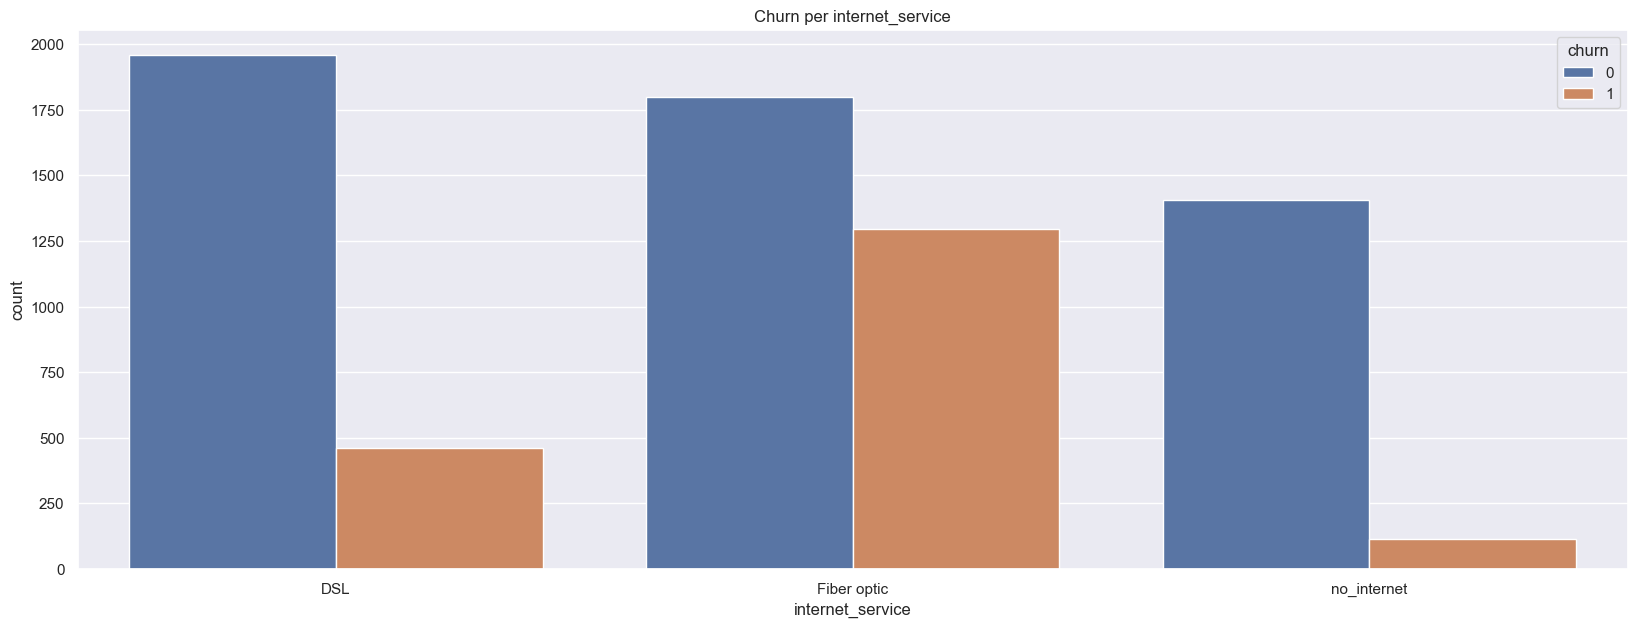

In [54]:
sns.countplot(data=df, x='internet_service', hue='churn').set_title(
    'Churn per internet_service')

Клиенты которые используют доступ к интернету по технологии оптической связи чаще разрывают контракты.

А как обстоит ситуация с оттоком в зависимости от использования антивируса?

Text(0.5, 1.0, 'Churn per dependents')

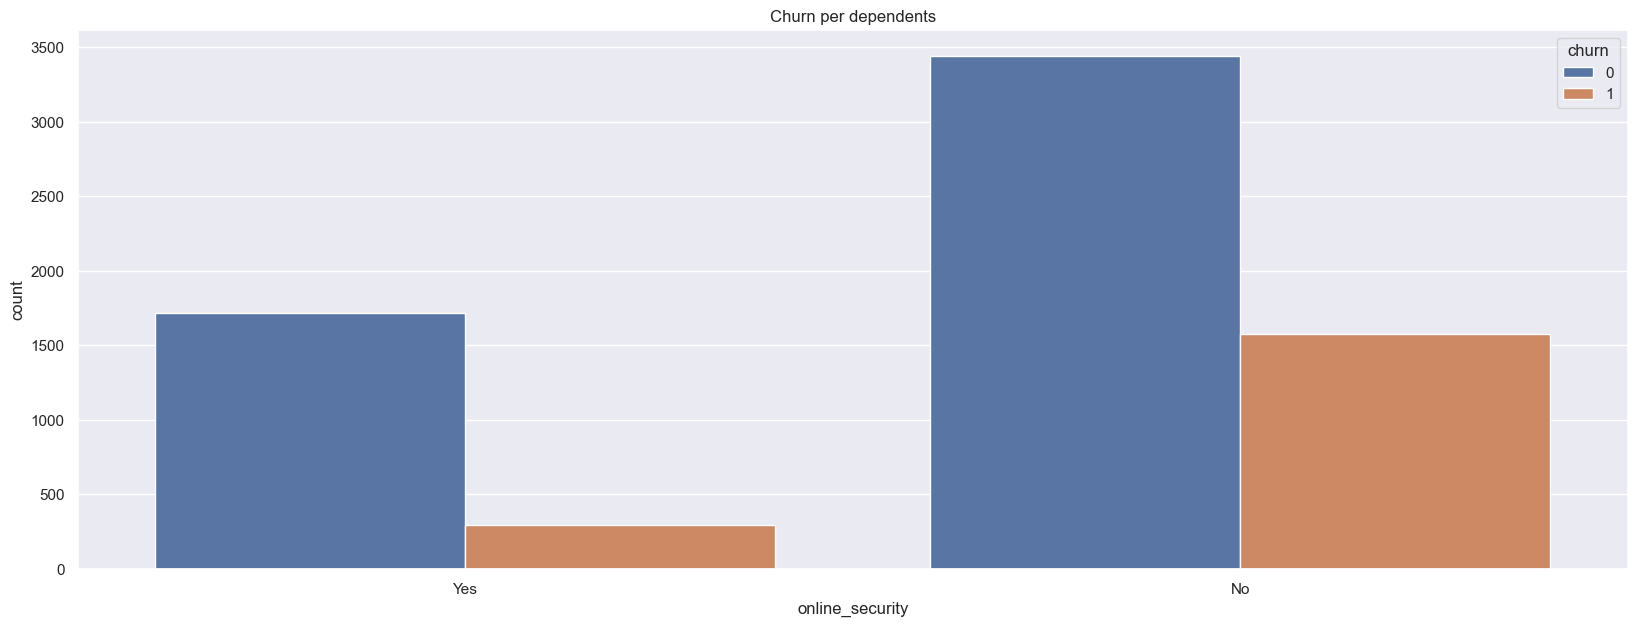

In [55]:
sns.countplot(data=df, x='online_security',
              hue='churn').set_title('Churn per dependents')

Абоненты которые пользуются блокировкой опасных сайтов реже разрывают контракты.

Text(0.5, 1.0, 'Churn per dependents')

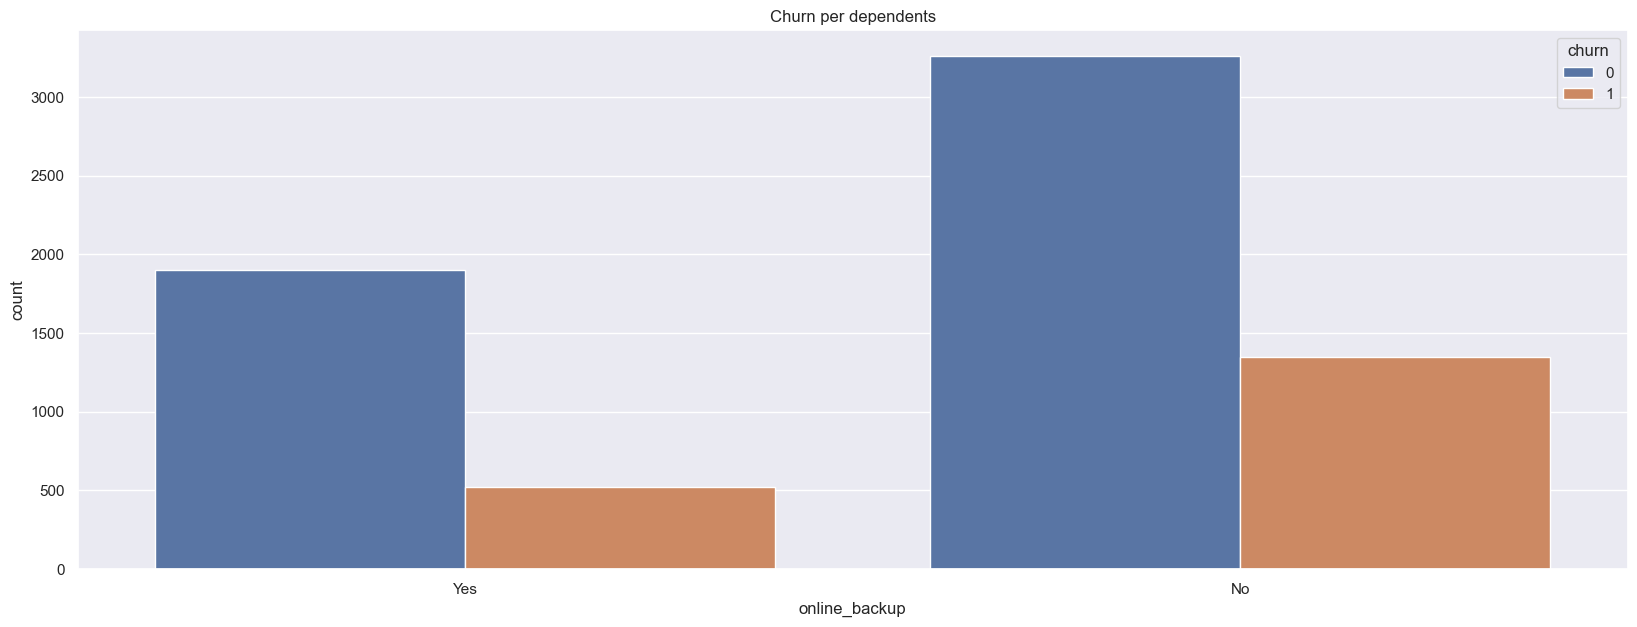

In [56]:
sns.countplot(data=df, x='online_backup', hue='churn').set_title(
    'Churn per dependents')

In [57]:
df[df.online_backup == 'Yes']['churn'].mean()

0.2156701030927835

In [58]:
df[df.online_backup == 'No']['churn'].mean()

0.29216409811156935

Такая же картина и для клиентов которые используют облачное хранилище файлов для резервного копирования данных.

Text(0.5, 1.0, 'Churn per dependents')

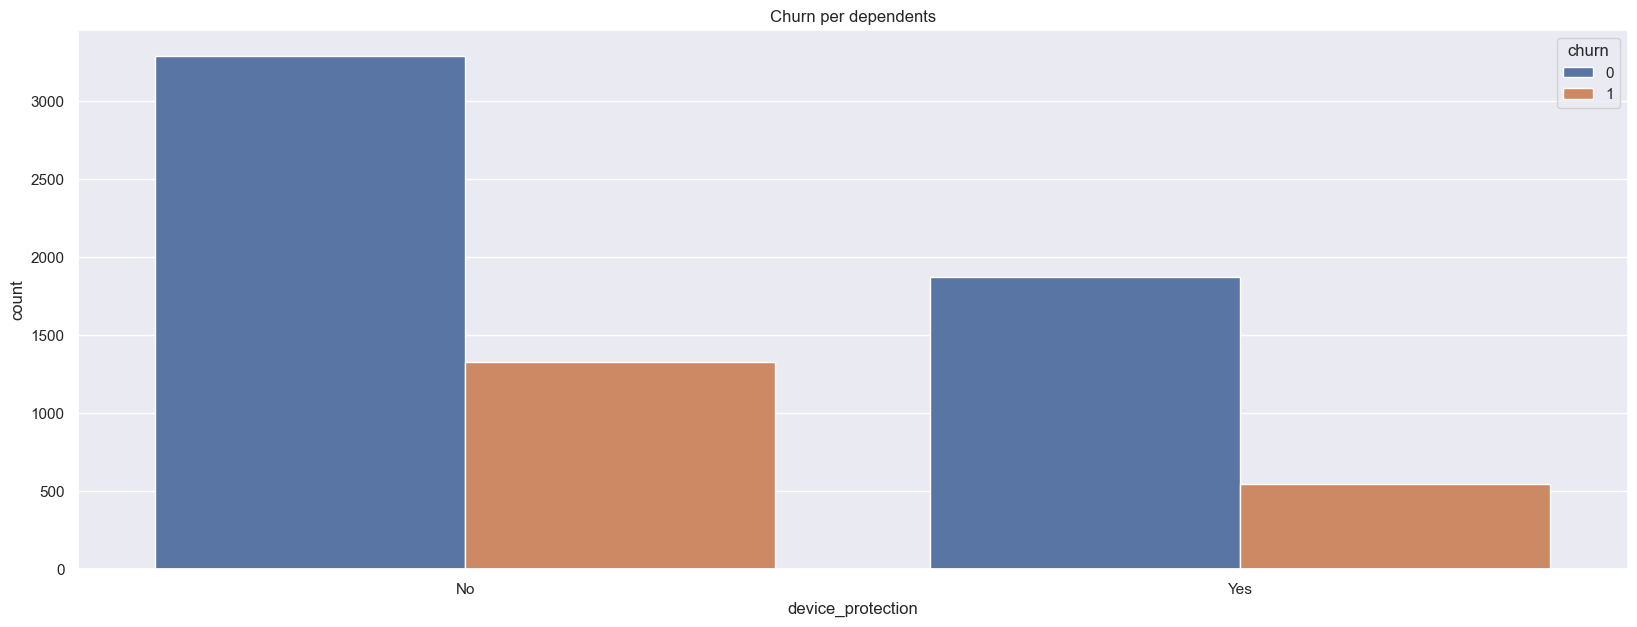

In [59]:
sns.countplot(data=df, x='device_protection',
              hue='churn').set_title('Churn per dependents')

In [60]:
df[df.device_protection == 'Yes']['churn'].mean()

0.22539288668320925

In [61]:
df[df.device_protection == 'No']['churn'].mean()

0.28695275249241436

Как и у клиентов использующих антивирус.

Text(0.5, 1.0, 'Churn per dependents')

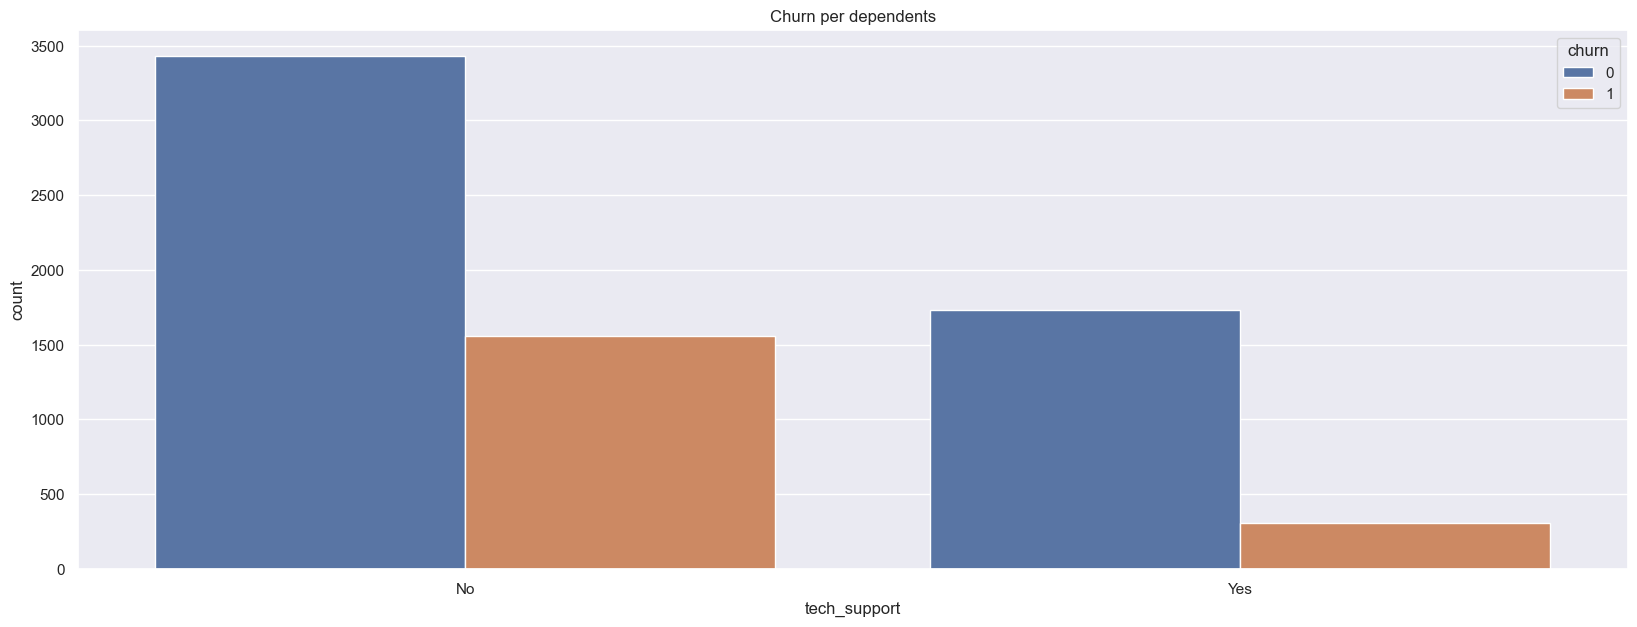

In [62]:
sns.countplot(data=df, x='tech_support', hue='churn').set_title(
    'Churn per dependents')

Клиенты которые имеют выделенную линию технической поддержки реже разрывают контракты.

Text(0.5, 1.0, 'Churn per dependents')

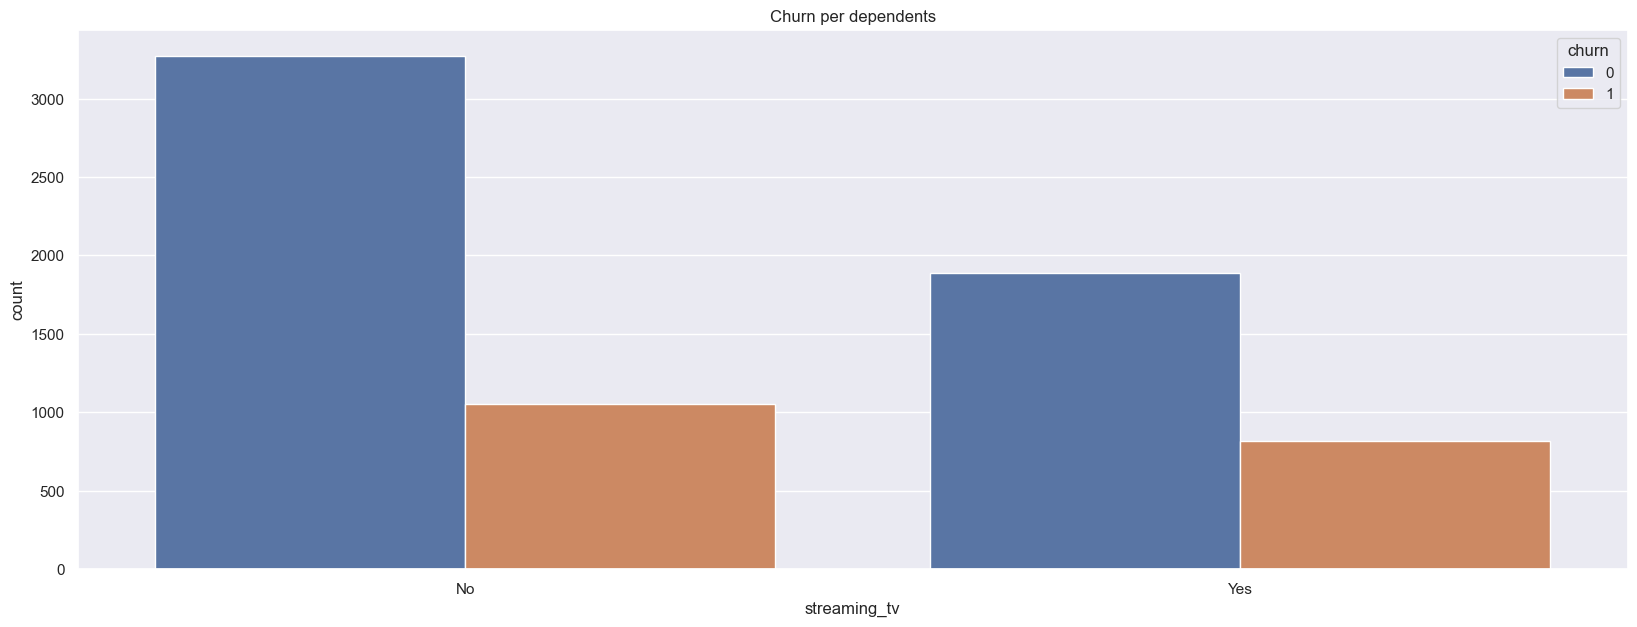

In [63]:
sns.countplot(data=df, x='streaming_tv', hue='churn').set_title(
    'Churn per dependents')

А ситуация со стриминговым телевидением координальная, пользователи сервиса чаще разрывают контракты.

Text(0.5, 1.0, 'Churn per dependents')

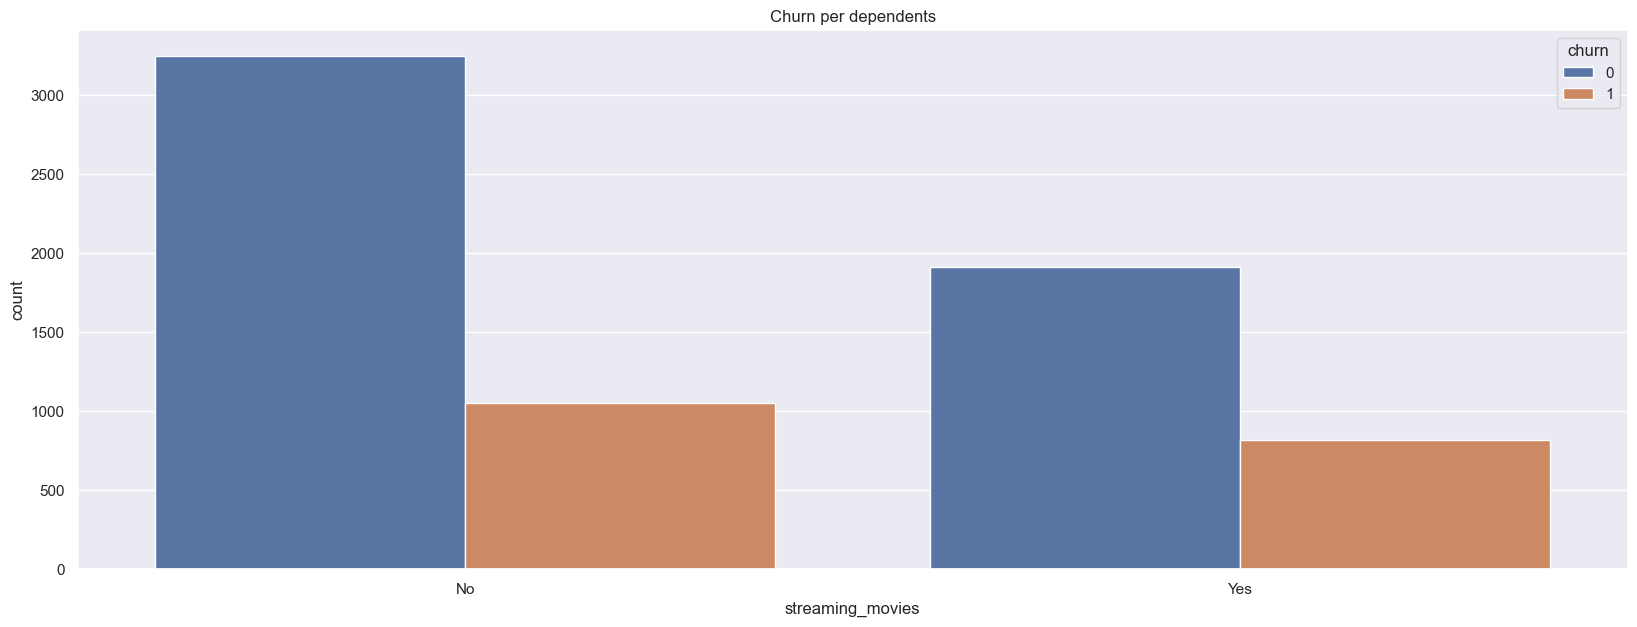

In [64]:
sns.countplot(data=df, x='streaming_movies',
              hue='churn').set_title('Churn per dependents')

Как и с каталогом фильмов, пользователи которого аналогично стримминговому телевидению - чаще разрывают контракты.

In [65]:
t_table = df.groupby([df.internet_service, df.churn])[
    'total_charges'].agg('mean')

### Phone

Проведем ознакомление и анализ таблицы **phone**.

Взглянем на общую информацию о датафрейме:

In [66]:
phone = data_dict['telecom.phone']

phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Как мы можем видеть из таблице выше, у нас какая-то проблема с именами колонок, взглянем на несколько строк датасета:

In [67]:
phone.head()

,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


Имена колонок оказались в первой строке датасета, это может быть связанно с ошибкой таблицы базы SQL, в реальной ситуации можем проконсультироваться с коллегами ответсвенными за администрирование базы данных, в нашем случае извлечем имена колонок из первой строки и приведем их к snake_case:

In [68]:
phone.columns = phone[0:1].values.tolist()[0]
phone = phone.drop([0])
phone.columns = ['customer_id', 'multiple_lines']
phone.head()

,customer_id,multiple_lines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [69]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Датафрейм `phone` имеет 2 столбца и 6361 строк:
* **customer_id** — 6361 значение, тип данных **object**, пропусков нет;
* **multiple_lines** — 6361 значение, тип данных **object**, пропусков нет;

Судя по количеству строк в датасете **phone** (6361) в отношении уникальных записей customer_id в датафрейме **contract**(7043) не все клиенты используют телефон.

Проверим на уникальность столбец **customer_id**:

In [70]:
phone.customer_id.unique().shape[0]

6361

Все значения customer_id уникальны.

Поищем неявные дубликаты:

In [71]:
phone.multiple_lines.unique()

array(['No', 'Yes'], dtype=object)

Неявных дубликатов не обнаружено.

Для дальнейшего анализа соединим датафрейм **phone** с общим датафреймом **data**:

In [72]:
df = df.merge(phone, left_on='customer_id', right_on='customer_id', how='left')
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,total_charges,churn,month_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,108.15,1,15.451613,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,151.65,1,9.000000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,820.50,1,10.000000,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,3046.05,1,6.064516,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),5036.30,1,10.387097,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [73]:
df.isna().sum()

customer_id            0
begin_date             0
end_date               0
type                   0
paperless_billing      0
payment_method         0
total_charges          0
churn                  0
month_duration         0
gender                 0
senior_citizen         0
partner                0
dependents             0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
multiple_lines       680
dtype: int64

In [74]:
df['multiple_lines'] = df['multiple_lines'].fillna('no_phone')

df = df.dropna()

In [75]:
df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,total_charges,churn,month_duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,108.15,1,15.451613,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
1,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,151.65,1,9.000000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
2,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,820.50,1,10.000000,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
3,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,3046.05,1,6.064516,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
4,0280-XJGEX,2018-11-13,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),5036.30,1,10.387097,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


Text(0.5, 1.0, 'Churn per internet_service')

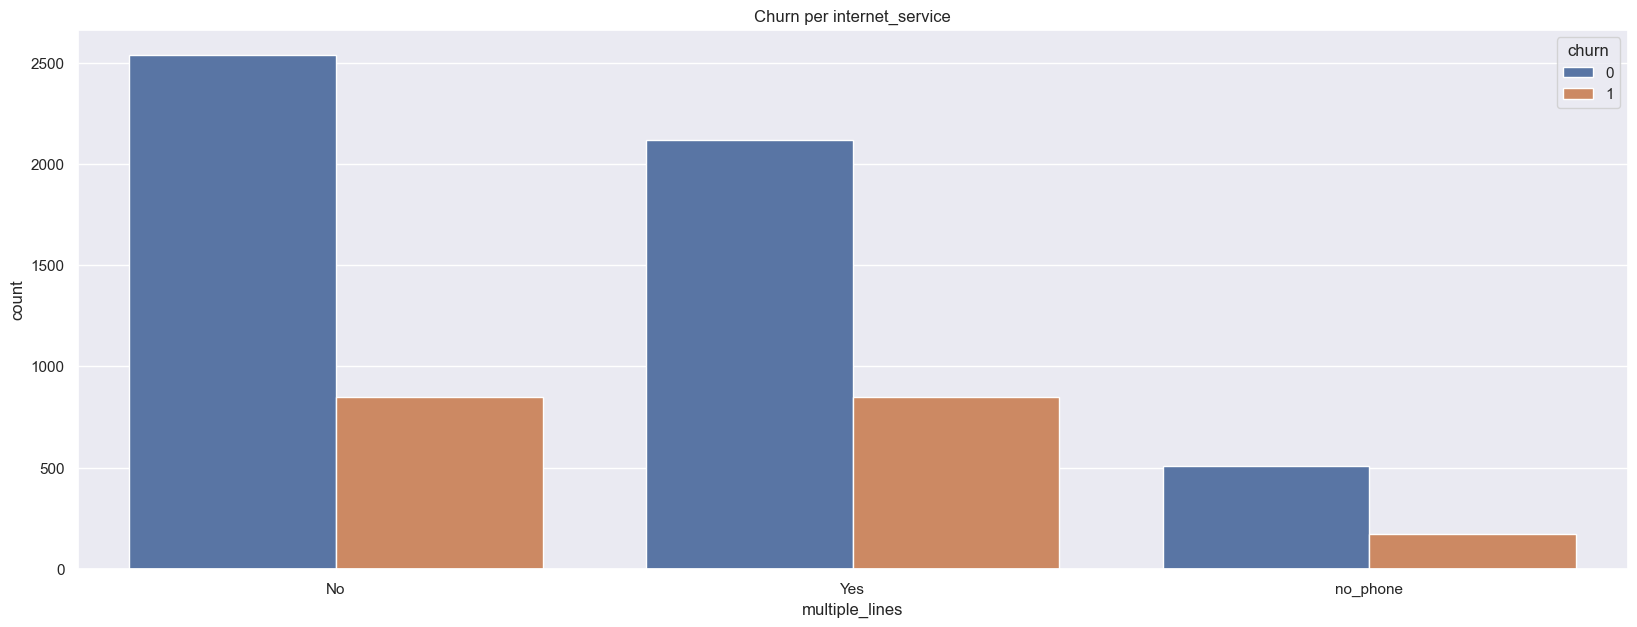

In [76]:
sns.countplot(data=df, x='multiple_lines', hue='churn').set_title(
    'Churn per internet_service')

Сontinuous features


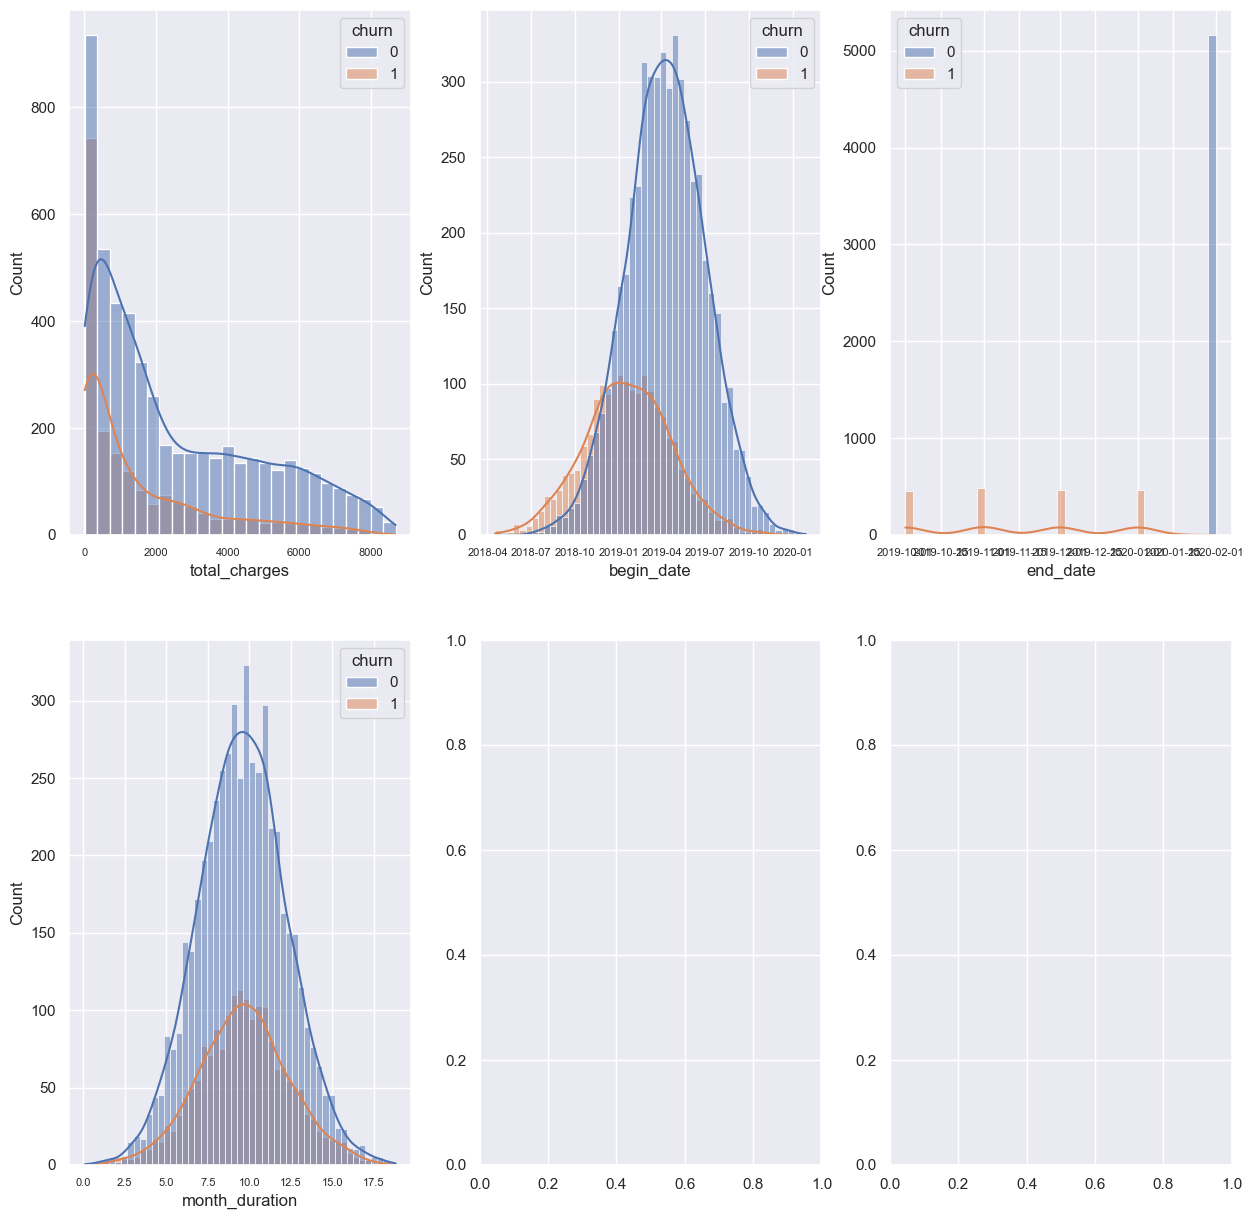

In [77]:
def stat_plot(columns, df):
    ncols = 3
    count_cols = 0
    count_rows = 0
    
    if len(columns) <= 3:
        fig, axs = plt.pyplot.subplots(ncols=ncols)
        for column in columns:
            sns.histplot(data=df, x=df[column], kde=True, hue='churn', ax=axs[count_cols]).tick_params(axis='x', labelsize=8)
            count_cols += 1
    else:
        nrows = math.ceil(len(columns) / ncols)
        fig, axs = plt.pyplot.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15))
        
        for column in columns:
            sns.histplot(data=df, x=df[column], kde=True, hue='churn', ax=axs[count_rows][count_cols]).tick_params(axis='x', labelsize=8)
            count_cols += 1
        
            if count_cols == ncols:
                count_cols = 0
                count_rows += 1
    

    
        
print('Сontinuous features')
columns = ['total_charges', 'begin_date', 'end_date', 'month_duration']      
stat_plot(columns, df)

Cat features


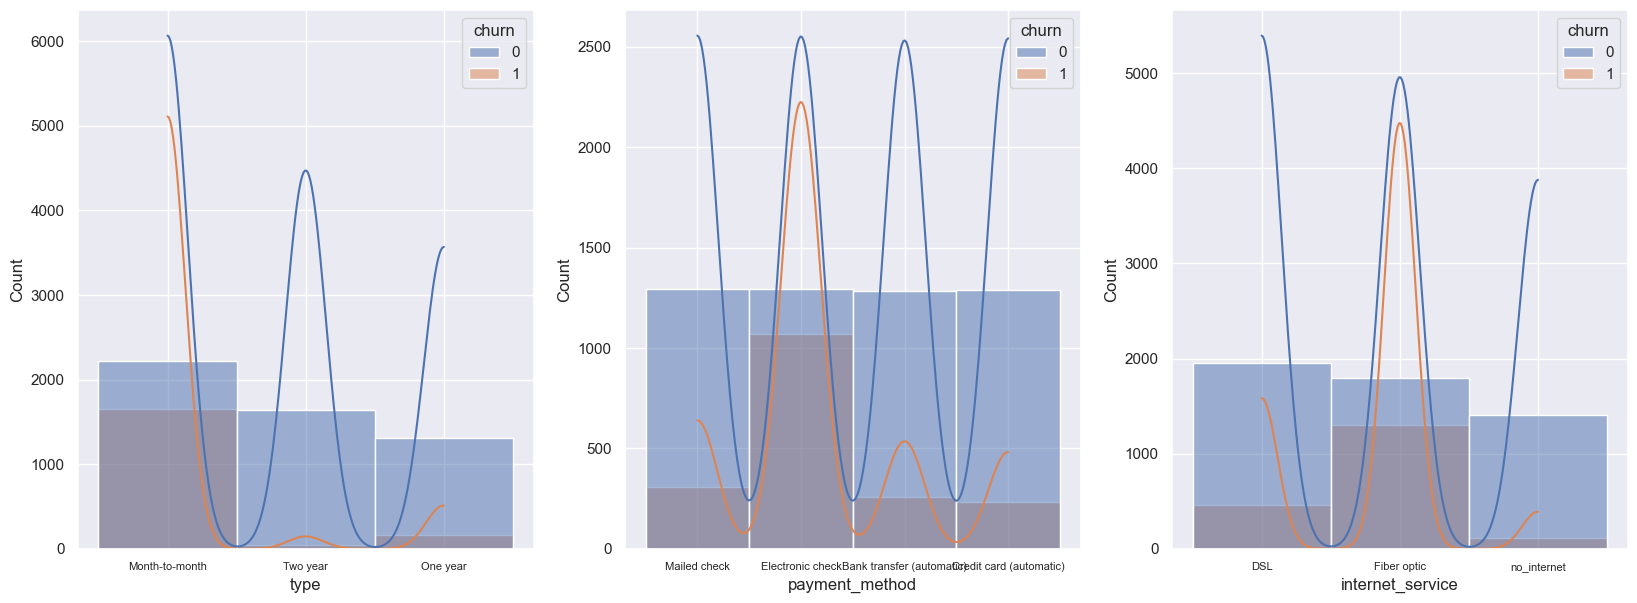

In [78]:
print('Cat features')
columns = ['type', 'payment_method', 'internet_service']
stat_plot(columns, df)

Binary features


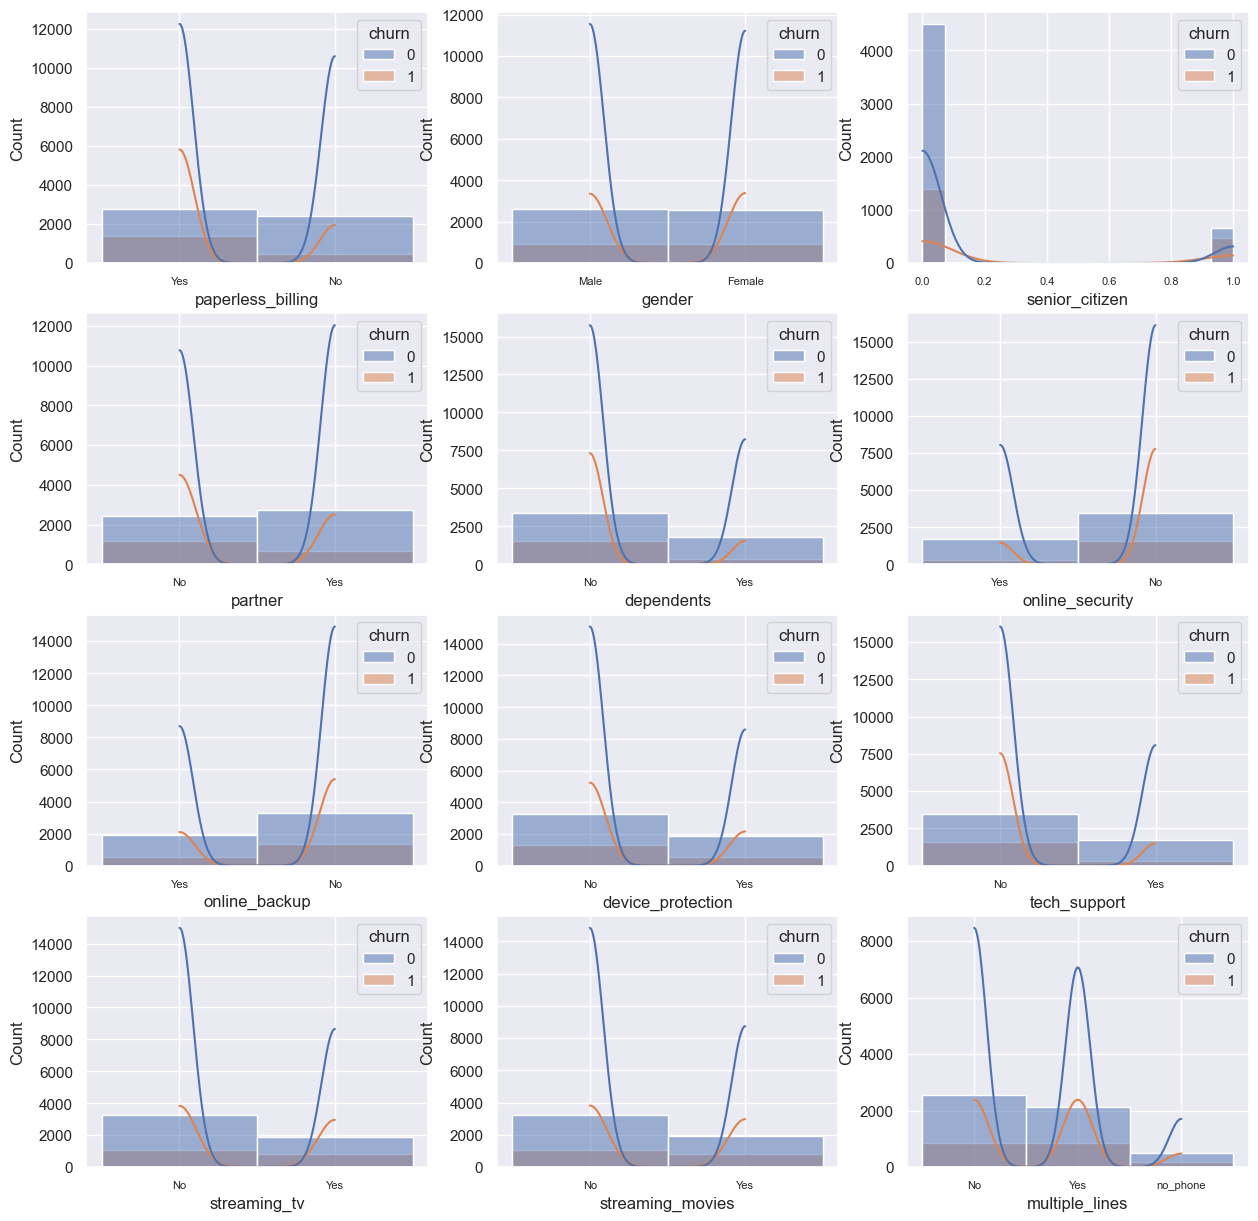

In [79]:
print('Binary features')
columns = ['paperless_billing', 'gender', 'senior_citizen', 'partner', 'dependents', 'online_security',
           'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
stat_plot(columns, df)

Удалим не нужные столбцы:

In [80]:
drop_columns = ['customer_id', 'begin_date', 'end_date', 'gender']

clear_df = df.drop(drop_columns, axis=1)

Колонки содержащие значения: 'No', 'Yes' приведем к 0, 1:

In [81]:
clear_df.head()

,type,paperless_billing,payment_method,total_charges,churn,month_duration,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Mailed check,108.15,1,15.451613,0,No,No,DSL,Yes,Yes,No,No,No,No,No
1,Month-to-month,Yes,Electronic check,151.65,1,9.000000,0,No,No,Fiber optic,No,No,No,No,No,No,No
2,Month-to-month,Yes,Electronic check,820.50,1,10.000000,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
3,Month-to-month,Yes,Electronic check,3046.05,1,6.064516,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
4,Month-to-month,Yes,Bank transfer (automatic),5036.30,1,10.387097,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [82]:
yes_no_list = ['No', 'Yes']

for column in clear_df.columns:

    if sorted(clear_df[column].unique().tolist()) == yes_no_list:
        clear_df.loc[:, column] = clear_df[column].apply(
            lambda x: 1 if x == 'Yes' else 0)

Приведем данные к нужным типам:

In [83]:
int_columns = ['senior_citizen', 'partner', 'dependents', 'paperless_billing',
               'online_security', 'total_charges',
               'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies']

clear_df[int_columns] = clear_df[int_columns].astype('int')

In [84]:
clear_df.dtypes

type                  object
paperless_billing      int32
payment_method        object
total_charges          int32
churn                  int64
month_duration       float64
senior_citizen         int32
partner                int32
dependents             int32
internet_service      object
online_security        int32
online_backup          int32
device_protection      int32
tech_support           int32
streaming_tv           int32
streaming_movies       int32
multiple_lines        object
dtype: object

Проверим данные на дубликаты:

In [85]:
first_size = clear_df.shape[0]
print(f'Размер датасета до удаления дубликатов {first_size}')

clear_df.duplicated().sum()
clear_df = clear_df.drop_duplicates()

second_size = clear_df.shape[0]
delete_row = first_size - second_size

print(f'Размер датасета после удаления дубликатов {second_size}')
print(f'Удалено строк {delete_row}')

Размер датасета до удаления дубликатов 7032
Размер датасета после удаления дубликатов 7030
Удалено строк 2


Посмотрим на корреляцию числовых признаков:

interval columns not set, guessing: ['paperless_billing', 'total_charges', 'churn', 'month_duration', 'senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


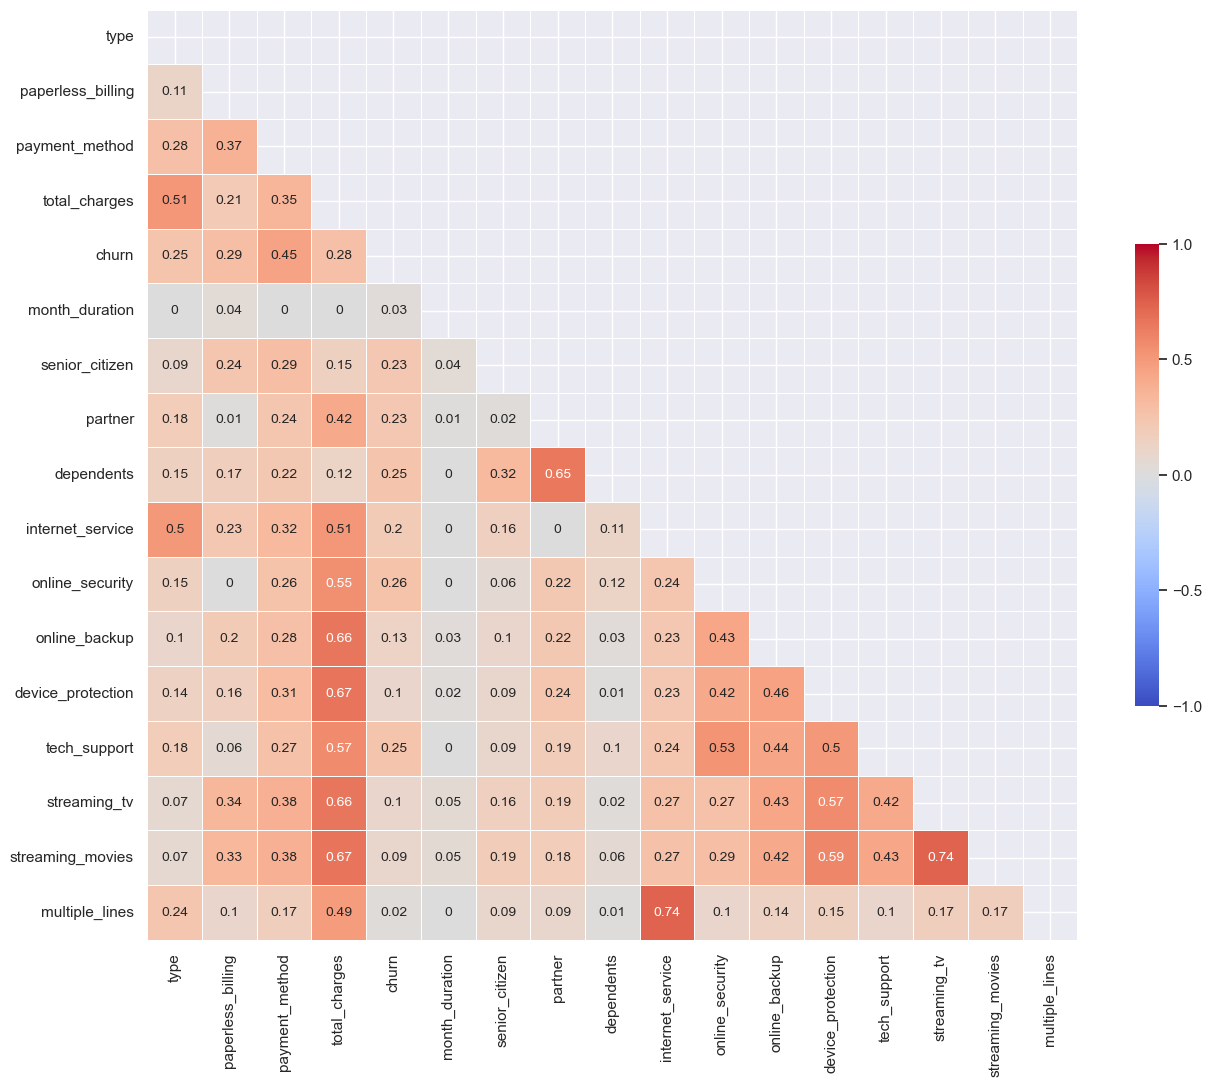

In [86]:
corr_matrix = clear_df.phik_matrix()

mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool_))

f, ax = plt.pyplot.subplots(figsize=(15, 15))
heatmap = sns.heatmap(round(corr_matrix, 2),
                      mask=mask,
                      square=True,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 10})

ax.set_yticklabels(corr_matrix.columns, rotation=0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Как мы можем видеть из диаграммы корреляции:
* Есть корреляция целевого признака с абонентами пенсионерами
* Есть корреляция целевого признака с абонентами которые получают бумажные счета
* Есть корреляция целевого признака с месячными расходами абонента

Для предобработки наших данных мы будем использовать OHE кодирование категориальных признаков, с аргументом drop='first' для того чтобы избежать dummy ловушки затем производим скалирование при помощи StandardScaler(), предобработка и модель собираются в пайплайн при помощи функции create_pipeline:

In [87]:
def create_pipeline(model):
    transformer = ColumnTransformer(
        transformers=[
            ("ohe", OneHotEncoder(drop='first'), make_column_selector(dtype_include=["category", "object"])),
            ("scaler", StandardScaler(), make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough",
        n_jobs=-1,
    )
    
    clf = Pipeline(
    steps=[("transformer", transformer), ("classifier", model)]
    )
    return clf

Выделим целевой признак:

In [90]:
clear_df = clear_df.reset_index(drop=True)

target = clear_df['churn']
features = clear_df.drop('churn', axis=1)

Разделим данные на тренировочную и тестовую выборки в соотношении 1 к 4: 

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_SEED, stratify=target)

X_train.shape, X_test.shape

((5272, 16), (1758, 16))

Посмотрим на распределение целевого признака в тренировочной выборке:

Text(0.5, 1.0, 'Target features distribution train sample')

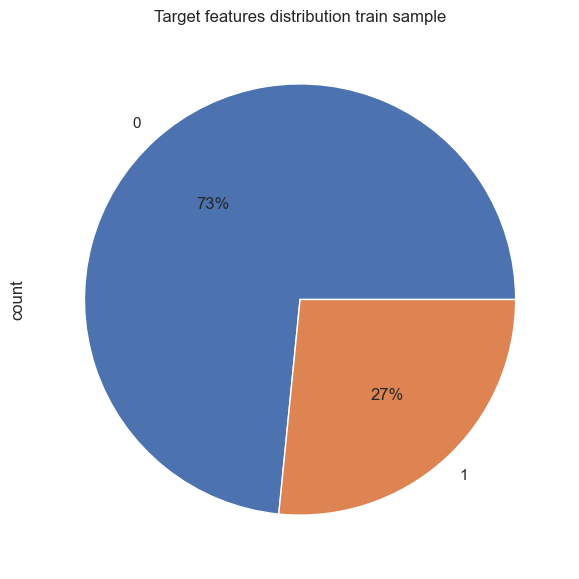

In [92]:
y_train.value_counts().plot(kind='pie', autopct='%.0f%%').set_title(
    'Target features distribution train sample')

Как мы видим из данных диаграммы выше - в нашем датасете дисбаланс классов. 

Некоторые модели "из коробки" могут работать с такими данными, но в рамках этого проекта я не буду производить upsamling, т.к. при обучении моделей на сэмплированной выборке - метрики на тренировочной выборке получаются завышенными а точность на тестовой не возрастает.

In [93]:
def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = repeat
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_SEED)
    return features_upsampled, target_upsampled

# X_train, y_train = upsample(X_train, y_train, 2)


print(X_train.shape)
print(y_train.shape)

(5272, 16)
(5272,)


Посмотрим на результат:

Text(0.5, 1.0, 'Upsampling target features distribution train sample')

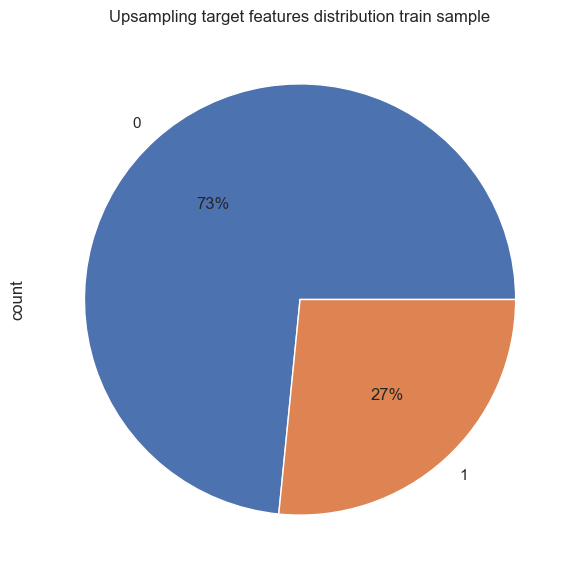

In [94]:
y_train.value_counts().plot(kind='pie', autopct='%.0f%%').set_title(
    'Upsampling target features distribution train sample')

На этапе EDA и предобработки данных мы подготовили данные а затем проанализировали их:
* Выполнили анализ каждой таблицы и объединили их в общий датасет по ID клиента.
* Обработали пропущенные значения.
* Проанализировали отток клиентов в разрезе времени.
* Выделили дополнительный признак - длительность контракта.
* Выделили целевой признак 'churn'.
* Провели корреляционный анализ.
* Выяснили что данные по месячным и полным расходам не совпадают с длительностью контрактов.
* Выбрали признаки для обучающего датасета.
* Привели данные к нужным типам.
* Раздели данные на тренировочную и тестовую части.

## Обучение моделей

На этапе обучения моделей для начала мы протестируем: 'DummyClassifier', 'DecisionTreeClassifier', 'CatBoostClassifier', 'RandomForestClassifier'. В качестве целевой метрики будем использовать 'roc_auc'.

Сравним результаты и выберем модель показавшую наилучший результат.

Затем произведем подбор гиперпараметров посредством библиотеки Optuna.

Также по условиям проекта мы булем использовать кросс валидацию на 3-х фолдах.

В качестве baseline используем DummyClassifier(), создадим список моделей и функцию для первичной оценки целевой метрики на тестовой выборке, результаты поместим в список для дальнейшей оценки:

In [95]:
train_scores = []
model_name_list = ['DummyClassifier',
 'DecisionTreeClassifier',
 'CatBoostClassifier',
 'RandomForestClassifier']

model_list = [DummyClassifier(random_state=RANDOM_SEED),
              DecisionTreeClassifier(random_state=RANDOM_SEED), CatBoostClassifier(
                  random_seed=RANDOM_SEED, verbose=0),
              RandomForestClassifier()]


N_SPLITS = 3
skf = StratifiedKFold(
    n_splits=N_SPLITS, random_state=RANDOM_SEED, shuffle=True)


def first_score(model):
    pipeline = create_pipeline(model)
    cv_results = cross_val_score(pipeline, # Pipeline
                             X_train, # Feature matrix
                             y_train, # Target vector
                             cv=skf, # Cross-validation technique
                             scoring='roc_auc', # Loss function
                             n_jobs=-1) # Use all CPU cores
    
    return np.mean(cv_results)


for model in model_list:
    train_scores.append(first_score(model))

Протестируем класс нейронных моделей:

In [96]:
def create_larger():
    model = Sequential()
    model.add(Dense(60, input_shape=(21, ), activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
                  'accuracy', tf.keras.metrics.AUC(curve='ROC')])

    return model


model = KerasClassifier(model=create_larger, epochs=20, verbose=0)
train_scores.append(first_score(model))


model_name_list.append('KerasNN')
model_list.append(model)

Создаем датафрейм для анализа результатов:

In [97]:
model_score_dict = {'model_name': model_name_list,
                    'roc_auc': train_scores}

stat_table = pd.DataFrame(model_score_dict)
stat_table.sort_values('roc_auc', ascending=False).reset_index(drop=True).style.highlight_max(
    color='yellowgreen', subset='roc_auc').highlight_min(color='coral', subset='roc_auc')

,model_name,roc_auc
0,CatBoostClassifier,0.837585
1,RandomForestClassifier,0.820985
2,KerasNN,0.817236
3,DecisionTreeClassifier,0.660614
4,DummyClassifier,0.500000


Наилучшую метрику показала модель CatBoostClassifier с результатом 0.835.

Произведем подбор гиперпараметров модели при помощи библиотеки Optuna:

In [98]:
def objective(trial):

    all_scores = []

    print('=' * 12 + f'START' + 12 * '=')
    param = {'iterations': trial.suggest_int('iterations', 1, 1000),
             'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
             'depth': trial.suggest_int('depth', 5, 5)}

    model = CatBoostClassifier(
        **param, loss_function='Logloss', random_seed=RANDOM_SEED, verbose=0)

    
    print('=' * 12 + f'STOP' + 12 * '=')
    return first_score(model)
    

if STUDY: 
    study = optuna.create_study(
        pruner=optuna.pruners.HyperbandPruner(), direction='maximize')
    study.optimize(objective, n_trials=1000, n_jobs=1)
    params = study.best_params

Финальное тестирование модели на тестовой части данных:

In [99]:
param = {'iterations': 266, 'learning_rate': 0.016501776459390643, 'depth': 5} #{'iterations': 154, 'learning_rate': 0.03701871181263105, 'depth': 5}

model = create_pipeline(CatBoostClassifier(**param, loss_function='Logloss',
                           random_seed=RANDOM_SEED, verbose=0))
model.fit(X_train, y_train)
prediction = model.predict_proba(X_test)[:, 1]

print(
    f'Финальная метрика roc_auc составила {roc_auc_score(y_test, prediction)}')

Финальная метрика roc_auc составила 0.8536889385749141


Модель показала результат 0.853 на тестовой части выборки. Это максимальное значение которого мне удалось добиться. Посмотрим на ROC-AUC кривую для оценки модели:

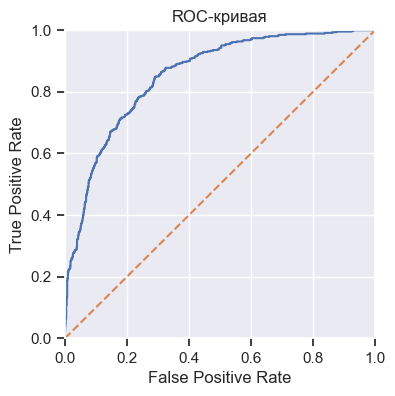

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
plt.pyplot.figure(figsize=(4, 4))
plt.pyplot.plot(fpr, tpr)
# ROC-кривая случайной модели
plt.pyplot.plot([0, 1], [0, 1], linestyle='--')
plt.pyplot.xlim([0.0, 1.0])
plt.pyplot.ylim([0.0, 1.0])
plt.pyplot.xlabel("False Positive Rate")
plt.pyplot.ylabel("True Positive Rate")
plt.pyplot.title("ROC-кривая")
plt.pyplot.show()

Подберем оптимальный порог классификации:

In [101]:
proba_one_X_test = model.predict_proba(X_test)[:, 1]
prediction = model.predict(X_test)
treshold_best, accuracy_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    accuracy = accuracy_score(y_test, y_pred)

    if accuracy > accuracy_best:
        accuracy_best = accuracy
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('Accuracy при подборе порога:', accuracy_best)
print('Recall при подборе порога:', recall_score(y_test, prediction))

Оптимальный порог классификации: 0.46
Accuracy при подборе порога: 0.8139931740614335
Recall при подборе порога: 0.4817987152034261


Посмотрим матрицу ошибок:

Text(0.5, 1.0, 'Confusion matrix for final testing CatBoostClassifier()')

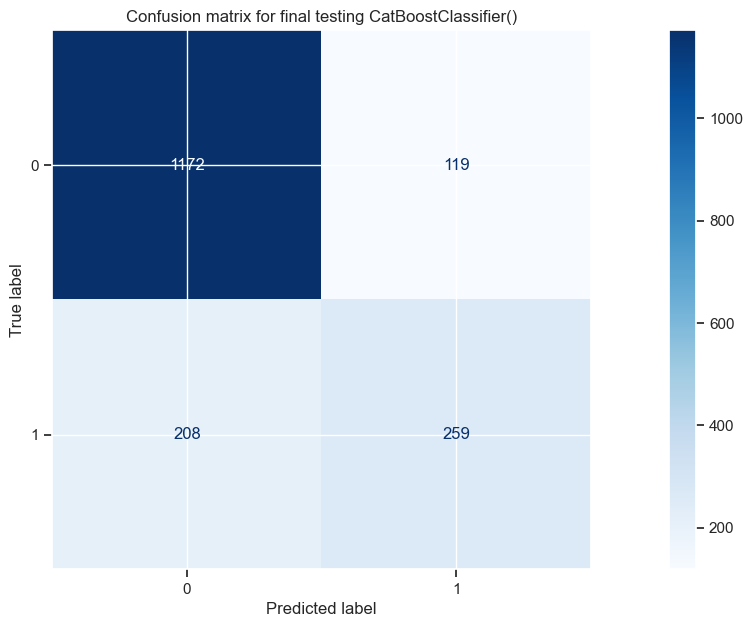

In [102]:
cm = confusion_matrix(y_test, model.predict_proba(
    X_test)[:, 1] > treshold_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion matrix for final testing CatBoostClassifier()')

Модель понимает данные, в 0 классе 90% TN, а вот в целевом классе дела обстоят не так хорошо, модель определила только 55% ушедших абонентов.

Посмотрим на важность признаков:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


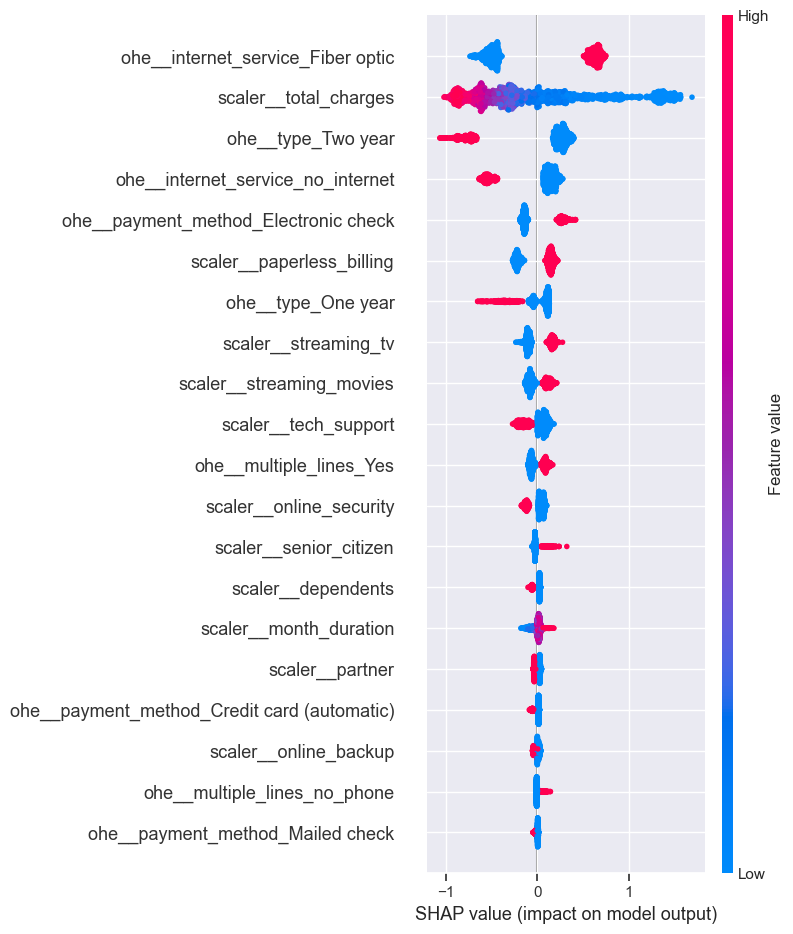

In [103]:
explainer = shap.Explainer(model["classifier"], feature_names=model['transformer'].get_feature_names_out())
data_transformation = model['transformer'].transform(X_test)

shap_values = explainer(data_transformation)

shap.summary_plot(shap_values, data_transformation)


Портрет уходящего клиента:
* Высокие месячные расходы
* Использует интернет
* Доступ к интернету по технологии оптической линии
* Тариф с месячной оплатой
* Платит электронным чеком

In [104]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[2:3, :], model['transformer'].transform(
    X_test.iloc[2:3, :]), feature_names=model['transformer'].get_feature_names_out(), plot_cmap='DrDb')

Для более углубленного анализа рассмотрим признак internet service:

## Анализ 'internet_service'

Напомню, самая высокая доля ушедших абонентов пользовалась интернетом по оптической линии

Text(0.5, 1.0, 'Mean total_charges per type of internet service')

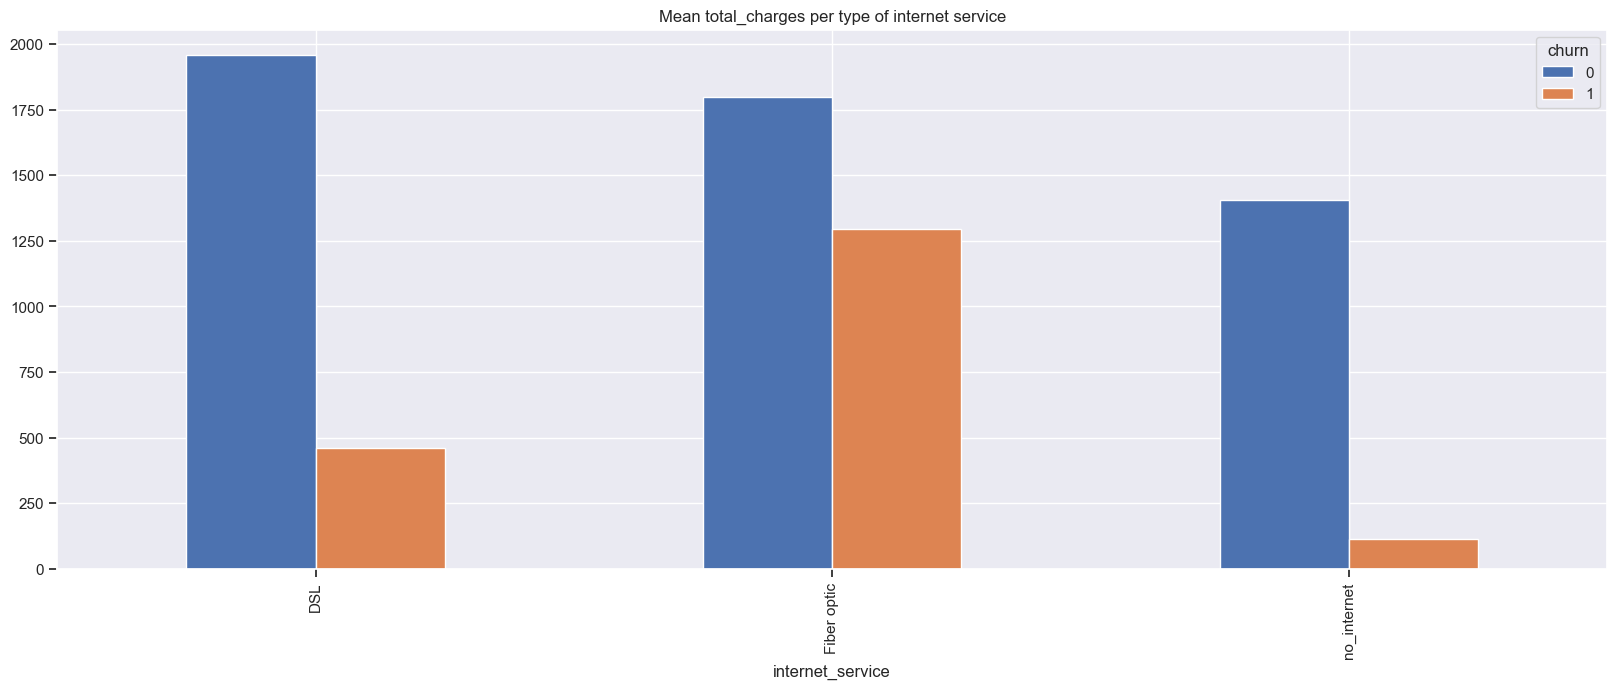

In [105]:
df.groupby(['internet_service', 'churn'])['internet_service'].agg('count').unstack(
).plot(kind='bar').set_title('Mean total_charges per type of internet service')

Может быть доступ к интернету по оптической линии и по технологии DSL были предложены абонентам в разное время:

Text(0.5, 1.0, 'Mean total_charges per type of internet service')

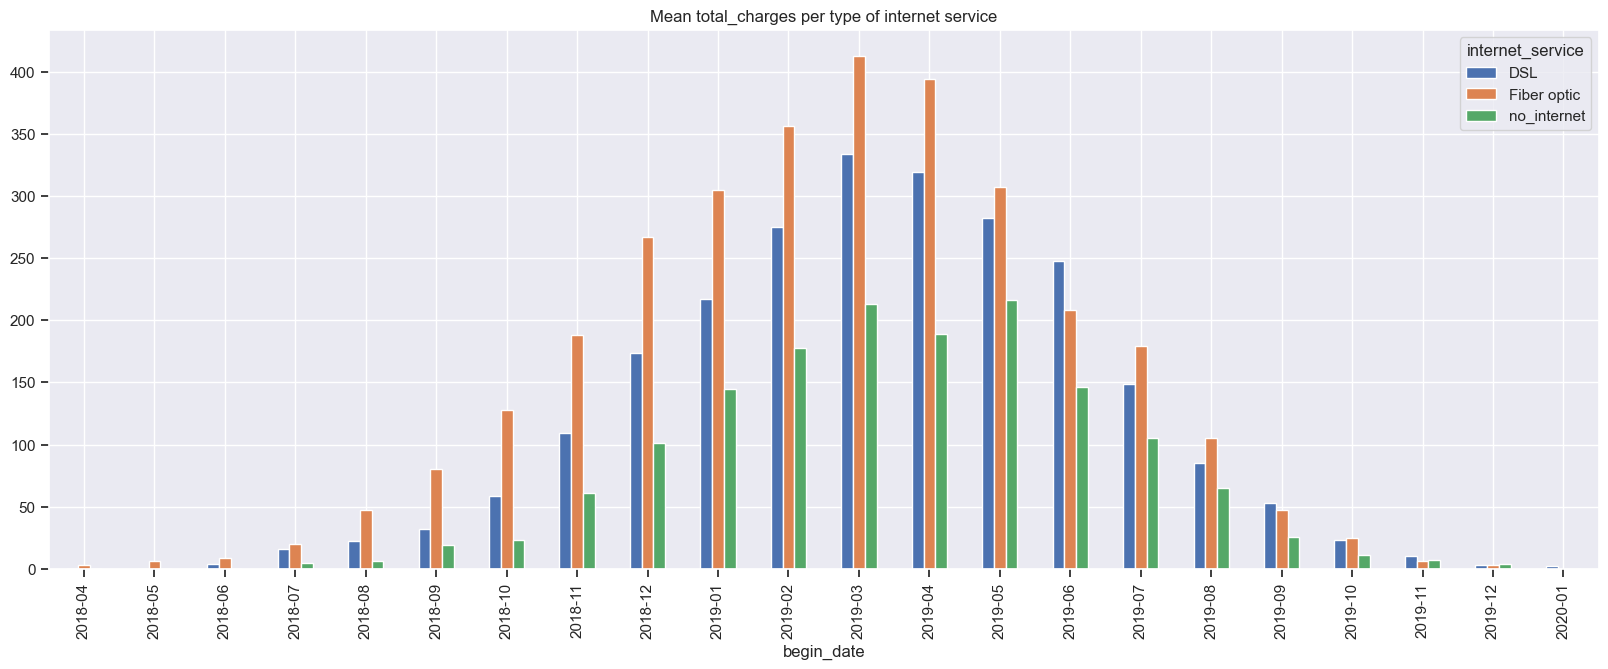

In [106]:
df.groupby([df.begin_date.dt.to_period('M'), 'internet_service'])['internet_service'].agg(
    'count').unstack().plot(kind='bar').set_title('Mean total_charges per type of internet service')

Как мы можем видеть обе технологии введены в равной степени и предлагались обонентам в одно время.

Посмотрим на полные расходы абонента по месячно в зависимости от технологии доступа к интернету для договоров с помесячной оплатой:

Text(0.5, 1.0, 'Mean total_charges per type of internet service')

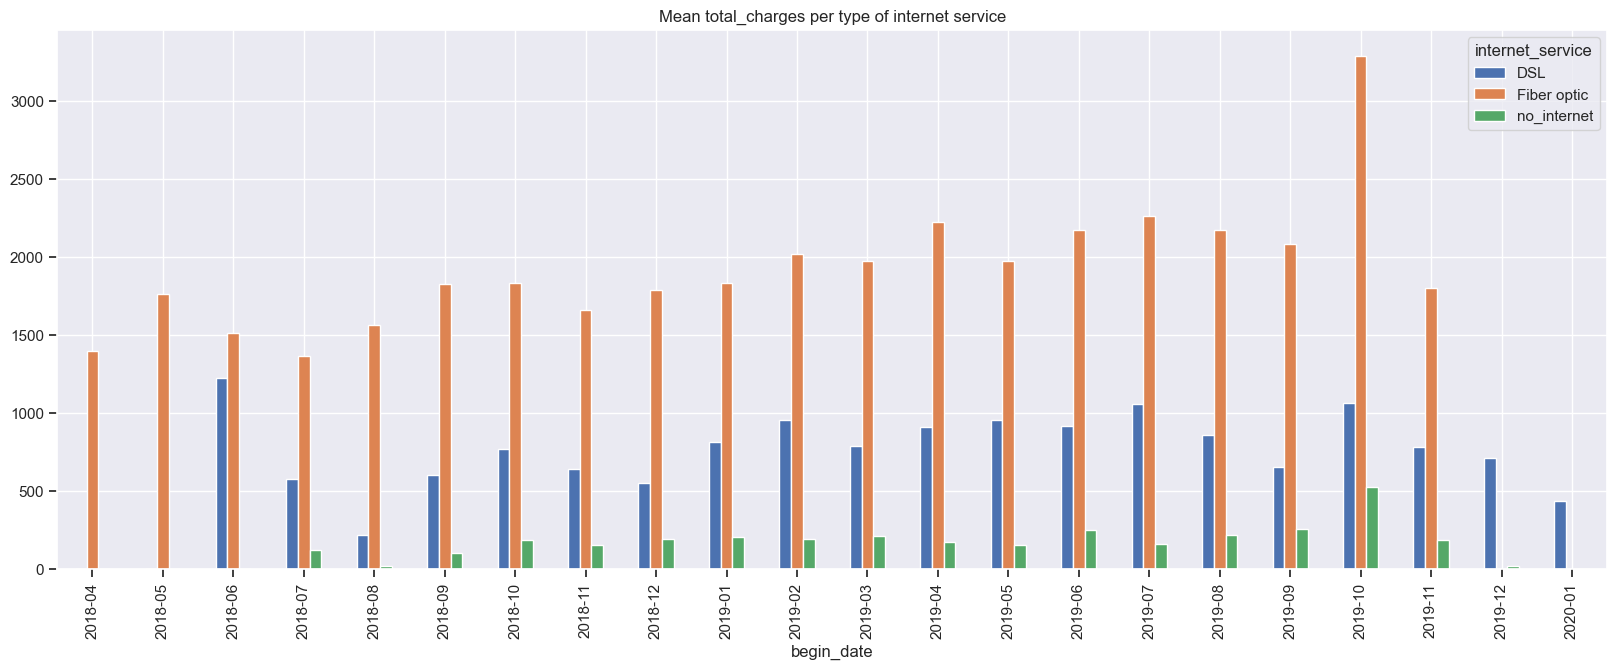

In [107]:
df[(df['type'] != 'Two year') & (df['type'] != 'One year')].groupby([df.begin_date.dt.to_period('M'), 'internet_service'])[
    'total_charges'].agg('mean').unstack().plot(kind='bar').set_title('Mean total_charges per type of internet service')

Как видно из графика, полные расходы абонентов которые подключены к интернету по оптивоколонной технологии почти в два раза выше абонентов использующих DSL.

### Общий вывод

В рамках данного проекта нашей основной задачей являлось создание модели предсказания ухода абонента. Проанализировав данные мы установили что распределение дат заключения контрактов ушедших абонентов по форме совпадает с распределение всех контрактов за исключением сдвинутого пика на три месяца ранее.

Мы установили факт что максимальная доля оттока абонентов являлась пользователями интернета по технологии оптической линии и месячные расходы этих абонентов превышают расходы абонентов по технологии DSL практически в 2 раза.

Какого-либо события которое повлияло на уход клиентов в контексте времени мы не нашли.

Объема данных которые предоставлены в данной задаче не хватает для разработки полноценной модели по заданным критериям.
Целевой метрикой данного проекта являлась ROC-AUC, пороговым значением 0.85.

Однозначного ответа почему уходят клиенты мы не получили, может это явление миграции клиентов в другую компанию или недовольство политикой тарифов нашей.

Для более детального анализа не хватает данных, я запросил бы дополнительную информацию:

* Детальная информация о платежах.
* Обращения в техподдержку
* Данные по использованию траффика, минут разговоров и смс.

А также неплохо было бы провести конкуретный анализ рынка телеком услуг.

По поводу использования данной модели в продакшене: на данном этапе модель может быть использована в продакшене после консультации с финансовым отделом, в качестве меры удержания клиентов могу предложить использование купонов на скидки или тарифных планов с персонализированными условиями, н-р снижение обонентской платы.

В этом проекте:

На этапе импорта библиотек и объявления констант:
* Мы импортировали нужные библиотеки, объявили константы, установили некоторве настройки.

На этапе загрузки данных:
* Сконфигурировали и установили соединение с базой данных заказчика.
* Выполнили загрузку необходимых таблиц.

На этапе EDA и преобработки данных:
* Ознакомились с информацией о каждой таблице.
* Выполнили анализ каждого признака.
* Соединили таблицы в единый датасет.
* Обработали пропуски и дубликаты.
* Разделили датасет на тренировочную и тестовую части.

На этапе обучения моделей:
* Произвели первичное тестирование нескольких типов моделей.
* По результатам первичного тестирования выбрали модель с наилучшей метрикой.
* Произвели подбор гиперпараметров модели, и получили финальную метрику ROC-AUC 0.854.
* Проанализировали матрицу ошибок и важность признаков.

На этапе Анализ 'internet_service':
* Проанализировали дополнительный признак.